## IMPORTAÇÕES

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
# Criação do dataframe
df_censo = pd.read_csv('database_dropout.csv')

## FUNÇÕES

In [4]:
def tratar_outliers_iqr(df, colunas, estrategia='remover', valor_substituicao='mediana', mostrar_stats=True):
    """
    Trata outliers usando o método IQR com diferentes estratégias.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo os dados
    colunas : list
        Lista de colunas para tratar outliers
    estrategia : str, opcional (default='remover')
        Estratégia para tratar outliers:
        - 'remover': remove registros com outliers
        - 'substituir': substitui outliers por um valor específico
    valor_substituicao : str ou float, opcional (default='mediana')
        Valor para substituir outliers quando estrategia='substituir':
        - 'mediana': usa a mediana da coluna
        - 'media': usa a média da coluna
        - 'limite': usa os limites do IQR
        - float: usa um valor específico
    mostrar_stats : bool, opcional (default=True)
        Se True, mostra estatísticas detalhadas do processo

    Retorna:
    --------
    pandas.DataFrame
        DataFrame com outliers tratados
    dict
        Dicionário com estatísticas do tratamento
    """

    # Criar cópia do DataFrame para não modificar o original
    df_tratado = df.copy()

    # Guardar quantidade inicial de registros
    total_inicial = len(df_tratado)
    if mostrar_stats:
        print("1. Total inicial:", total_inicial)
        print("\n2. Colunas sendo analisadas:")
        print(colunas)

    # Criar DataFrame para armazenar máscaras de outliers
    outliers_mask = pd.DataFrame(index=df_tratado.index)

    # Estatísticas para retorno
    stats = {
        'total_inicial': total_inicial,
        'outliers_por_coluna': {},
        'limites': {},
        'valores_substituicao': {}
    }

    # Processar cada coluna
    if mostrar_stats:
        print("\n3. Análise de outliers por coluna:")

    total_substituicoes = 0

    for col in colunas:
        # Calcular Q1, Q3 e IQR
        Q1 = df_tratado[col].quantile(0.25)
        Q3 = df_tratado[col].quantile(0.75)
        IQR = Q3 - Q1

        # Definir limites
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Identificar outliers
        mask = (df_tratado[col] < limite_inferior) | (df_tratado[col] > limite_superior)
        outliers_mask[col] = mask

        # Guardar estatísticas
        n_outliers = mask.sum()
        stats['outliers_por_coluna'][col] = n_outliers
        stats['limites'][col] = {
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'limite_inferior': limite_inferior,
            'limite_superior': limite_superior
        }

        if mostrar_stats:
            print(f"\nColuna: {col}")
            print(f"Q1: {Q1:.2f}")
            print(f"Q3: {Q3:.2f}")
            print(f"IQR: {IQR:.2f}")
            print(f"Limite inferior: {limite_inferior:.2f}")
            print(f"Limite superior: {limite_superior:.2f}")
            print(f"Número de outliers: {n_outliers}")
            print(f"Percentual de outliers: {(n_outliers/total_inicial)*100:.2f}%")

        # Substituir outliers se necessário
        if estrategia == 'substituir':
            if valor_substituicao == 'mediana':
                valor = df_tratado[col].median()
                stats['valores_substituicao'][col] = {'tipo': 'mediana', 'valor': valor}
            elif valor_substituicao == 'media':
                valor = df_tratado[col].mean()
                stats['valores_substituicao'][col] = {'tipo': 'media', 'valor': valor}
            elif valor_substituicao == 'limite':
                df_tratado.loc[df_tratado[col] < limite_inferior, col] = limite_inferior
                df_tratado.loc[df_tratado[col] > limite_superior, col] = limite_superior
                stats['valores_substituicao'][col] = {
                    'tipo': 'limite',
                    'inferior': limite_inferior,
                    'superior': limite_superior
                }
                continue
            else:
                valor = float(valor_substituicao)
                stats['valores_substituicao'][col] = {'tipo': 'valor_fixo', 'valor': valor}

            df_tratado.loc[mask, col] = valor
            total_substituicoes += n_outliers

    # Tratar registros com outliers
    if estrategia == 'remover':
        registros_com_outliers = outliers_mask.any(axis=1)
        df_tratado = df_tratado[~registros_com_outliers]

        if mostrar_stats:
            total_final = len(df_tratado)
            registros_removidos = total_inicial - total_final
            percentual_removido = (registros_removidos / total_inicial) * 100

            print("\n4. Resultado final (Remoção):")
            print(f"Quantidade inicial de registros: {total_inicial:,}")
            print(f"Registros removidos: {registros_removidos:,}")
            print(f"Quantidade final de registros: {total_final:,}")
            print(f"Percentual de registros removidos: {percentual_removido:.2f}%")

            stats.update({
                'total_final': total_final,
                'registros_removidos': registros_removidos,
                'percentual_removido': percentual_removido
            })
    else:  # estrategia == 'substituir'
        if mostrar_stats:
            print(f"\n4. Resultado final (Substituição):")
            print(f"Quantidade de registros: {total_inicial:,}")
            print(f"Total de valores substituídos: {total_substituicoes:,}")
            print(f"Percentual de valores substituídos: {(total_substituicoes/(total_inicial*len(colunas)))*100:.2f}%")
            print(f"\nMétodo de substituição: {valor_substituicao}")

            stats.update({
                'total_substituicoes': total_substituicoes,
                'percentual_substituido': (total_substituicoes/(total_inicial*len(colunas)))*100
            })

    return df_tratado, stats

In [5]:
def exibe_graficos_coluna(df, coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plotar histograma
    df_censo_eda[coluna].hist(ax=ax1)
    ax1.set_title(f'Histograma - {coluna}')
    ax1.tick_params(axis='x', rotation=45)

    # Plotar boxplot
    df_censo_eda.boxplot(column=coluna, ax=ax2)
    ax2.set_title(f'Boxplot - {coluna}')

    plt.tight_layout()
    plt.show()



In [6]:
def obter_outliers(df, coluna):
    """
    Retorna uma tupla com os outliers de uma coluna, seu limite superior e inferior utilizando IQR.
    """
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1

    outliers = df[(df[coluna] < (Q1 - 1.5 * IQR)) | (df[coluna] > (Q3 + 1.5 * IQR))][coluna]
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    return outliers, limite_inferior, limite_superior

In [7]:
def analise_outliers(df):
    # Selecionar apenas colunas numéricas
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # Criar um dataframe para armazenar os resultados
    outliers_summary = pd.DataFrame(columns=['Coluna', 'Total_Outliers', 'Percentual_Outliers', 'Limite_Inferior', 'Limite_Superior', 'Max_Real'])

    for col in numeric_cols:
        outliers, limite_inferior, limite_superior = obter_outliers(df, col)
        total_outliers = len(outliers)
        percentual_outliers = (total_outliers / len(df)) * 100

        # Calcular limites usando z-score
        media = df[col].mean()
        desvio_padrao = df[col].std()

        # Obter valor máximo real
        max_real = df[col].max()
        # Usar o menor valor entre o limite calculado e o máximo real
        limite_superior = min(limite_superior, max_real)

        # Adicionar resultados ao dataframe
        outliers_summary.loc[len(outliers_summary)] = [
            col,
            total_outliers,
            round(percentual_outliers, 2),
            round(limite_inferior, 2),
            round(limite_superior, 2),
            max_real
        ]

    # Ordenar por percentual de outliers
    outliers_summary = outliers_summary.sort_values('Percentual_Outliers', ascending=False)

    # Mostrar comparação com describe
    print("Comparação com estatísticas descritivas:")
    print("\nDescrição do DataFrame:")
    print(df[numeric_cols].describe())

    return outliers_summary

In [8]:
def analisar_relacao_aprovacoes(df):
    """
    Analisa a relação entre as taxas de aprovação do fundamental e médio
    """
    # Criar scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='TX_APROV_FUND', y='TX_APROV_MED', alpha=0.5)
    plt.title('Relação entre Taxas de Aprovação: Fundamental x Médio')
    plt.xlabel('Taxa de Aprovação - Fundamental')
    plt.ylabel('Taxa de Aprovação - Médio')

    # Adicionar linha de regressão
    sns.regplot(data=df, x='TX_APROV_FUND', y='TX_APROV_MED',
                scatter=False, color='red')

    # Calcular correlação
    corr = df['TX_APROV_FUND'].corr(df['TX_APROV_MED'])
    plt.text(0.05, 0.95, f'Correlação: {corr:.2f}',
             transform=plt.gca().transAxes)

    plt.show()

    # Estatísticas descritivas
    print("\nEstatísticas Descritivas:")
    print(df[['TX_APROV_FUND', 'TX_APROV_MED']].describe())

    return corr

In [9]:
def identificar_variaveis_importantes(df, target_col, n_vars=10):
    """
    Identifica as variáveis mais importantes para prever uma taxa de aprovação
    """
    # Selecionar apenas colunas numéricas
    df_num = df.select_dtypes(include=['float64', 'int64'])

    # Remover a coluna alvo das features
    features = df_num.drop(columns=[target_col])
    target = df_num[target_col]

    # Criar e treinar um modelo de Random Forest
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(features, target)

    # Obter importância das features
    importances = pd.DataFrame({
        'feature': features.columns,
        'importance': rf.feature_importances_
    })
    importances = importances.sort_values('importance', ascending=False)

    # Plotar importância das features
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importances.head(n_vars), x='importance', y='feature')
    plt.title(f'Top {n_vars} Variáveis Mais Importantes para {target_col}')
    plt.tight_layout()
    plt.show()

    return importances

## EDA

In [10]:
#informações do dataframe
df_censo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130129 entries, 0 to 130128
Data columns (total 52 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   NO_REGIAO                       130129 non-null  object 
 1   SG_UF                           130129 non-null  object 
 2   CO_MUNICIPIO                    130129 non-null  float64
 3   NO_MUNICIPIO                    130129 non-null  object 
 4   CO_ENTIDADE                     130129 non-null  float64
 5   NO_ENTIDADE                     130129 non-null  object 
 6   NO_CATEGORIA                    130129 non-null  object 
 7   NO_DEPENDENCIA                  130129 non-null  object 
 8   TX_APROV_FUND                   130129 non-null  float64
 9   TX_APROV_MED                    130129 non-null  float64
 10  TX_REPR_FUND                    130129 non-null  float64
 11  TX_REPR_MED                     130129 non-null  float64
 12  TX_DIS_FUND     

In [11]:
# Removendo colunas sem interesse
df_censo.drop(columns=['NO_REGIAO', 'SG_UF','CO_MUNICIPIO', 'NO_MUNICIPIO', 'CO_ENTIDADE','NO_ENTIDADE', 'NO_CATEGORIA','NO_DEPENDENCIA'], inplace=True)

Transformação e padronização dos dados

1. Transformação dos dados categóricos em numéricos

In [12]:
print(df_censo['TX_EV_TOT'])

0         Baixa
1         Baixa
2         Baixa
3         Baixa
4         Baixa
          ...  
130124    Baixa
130125    Baixa
130126    Baixa
130127    Baixa
130128    Baixa
Name: TX_EV_TOT, Length: 130129, dtype: object


In [13]:
print(df_censo['TX_EV_TOT'].unique())

['Baixa' 'Moderada' 'Alta']


In [14]:
encoder = OrdinalEncoder(categories=[['Baixa','Moderada','Alta']])
df_censo['TX_EV_TOT'] = encoder.fit_transform(df_censo[['TX_EV_TOT']])

In [15]:
print(df_censo['TX_EV_TOT'].unique())

[0. 1. 2.]


2. Padronização dos dados

In [16]:
# Copiar DF para DF EDA
df_censo_eda = df_censo.copy()

In [17]:
  # Converter para booleano
df_censo_eda['IN_INTERNET'] = df_censo_eda['IN_INTERNET'].astype(bool)
df_censo_eda['IN_SALA_PROFESSOR'] = df_censo_eda['IN_SALA_PROFESSOR'].astype(bool)
df_censo_eda['IN_AGUA_INEXISTENTE'] = df_censo_eda['IN_AGUA_INEXISTENTE'].astype(bool)
df_censo_eda['IN_ENERGIA_INEXISTENTE'] = df_censo_eda['IN_ENERGIA_INEXISTENTE'].astype(bool)
df_censo_eda['IN_ESGOTO_INEXISTENTE'] = df_censo_eda['IN_ESGOTO_INEXISTENTE'].astype(bool)
df_censo_eda['IN_TRATAMENTO_LIXO_INEXISTENTE'] = df_censo_eda['IN_TRATAMENTO_LIXO_INEXISTENTE'].astype(bool)
df_censo_eda['IN_AUDITORIO'] = df_censo_eda['IN_AUDITORIO'].astype(bool)
df_censo_eda['IN_BANHEIRO'] = df_censo_eda['IN_BANHEIRO'].astype(bool)
df_censo_eda['IN_BIBLIOTECA'] = df_censo_eda['IN_BIBLIOTECA'].astype(bool)
df_censo_eda['IN_LABORATORIO_INFORMATICA'] = df_censo_eda['IN_LABORATORIO_INFORMATICA'].astype(bool)
df_censo_eda['IN_PARQUE_INFANTIL'] = df_censo_eda['IN_PARQUE_INFANTIL'].astype(bool)
df_censo_eda['IN_PISCINA'] = df_censo_eda['IN_PISCINA'].astype(bool)
df_censo_eda['IN_REFEITORIO'] = df_censo_eda['IN_REFEITORIO'].astype(bool)
df_censo_eda['IN_SALA_LEITURA'] = df_censo_eda['IN_SALA_LEITURA'].astype(bool)
df_censo_eda['IN_SALA_PROFESSOR'] = df_censo_eda['IN_SALA_PROFESSOR'].astype(bool)
df_censo_eda['IN_ACESSIBILIDADE_INEXISTENTE'] = df_censo_eda['IN_ACESSIBILIDADE_INEXISTENTE'].astype(bool)
df_censo_eda['IN_QUADRA_ESPORTES'] = df_censo_eda['IN_QUADRA_ESPORTES'].astype(bool)

In [18]:
# converte  inteiros
df_censo_eda['QT_SALAS_UTILIZADAS'] = df_censo_eda['QT_SALAS_UTILIZADAS'].astype(int)
df_censo_eda['QT_SALAS_UTILIZA_CLIMATIZADAS'] = df_censo_eda['QT_SALAS_UTILIZA_CLIMATIZADAS'].astype(int)
df_censo_eda['QT_SALAS_UTILIZADAS_ACESSIVEIS'] = df_censo_eda['QT_SALAS_UTILIZADAS_ACESSIVEIS'].astype(int)
df_censo_eda['TP_REDE_LOCAL'] = df_censo_eda['TP_REDE_LOCAL'].astype(int)
df_censo_eda['QT_PROF_ADMINISTRATIVOS'] = df_censo_eda['QT_PROF_ADMINISTRATIVOS'].astype(int)
df_censo_eda['QT_PROF_SERVICOS_GERAIS'] = df_censo_eda['QT_PROF_SERVICOS_GERAIS'].astype(int)
df_censo_eda['QT_PROF_BIBLIOTECARIO'] = df_censo_eda['QT_PROF_BIBLIOTECARIO'].astype(int)
df_censo_eda['QT_PROF_SAUDE'] = df_censo_eda['QT_PROF_SAUDE'].astype(int)
df_censo_eda['QT_PROF_SEGURANCA'] = df_censo_eda['QT_PROF_SEGURANCA'].astype(int)
df_censo_eda['QT_PROF_GESTAO'] = df_censo_eda['QT_PROF_GESTAO'].astype(int)
df_censo_eda['QT_SALAS_UTILIZADAS'] = df_censo_eda['QT_SALAS_UTILIZADAS'].astype(int)
df_censo_eda['QT_SALAS_UTILIZA_CLIMATIZADAS'] = df_censo_eda['QT_SALAS_UTILIZA_CLIMATIZADAS'].astype(int)
df_censo_eda['QT_SALAS_UTILIZADAS_ACESSIVEIS'] = df_censo_eda['QT_SALAS_UTILIZADAS_ACESSIVEIS'].astype(int)
df_censo_eda['QT_PROF_ALIMENTACAO'] = df_censo_eda['QT_PROF_ALIMENTACAO'].astype(int)

In [19]:
df_censo_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130129 entries, 0 to 130128
Data columns (total 44 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   TX_APROV_FUND                   130129 non-null  float64
 1   TX_APROV_MED                    130129 non-null  float64
 2   TX_REPR_FUND                    130129 non-null  float64
 3   TX_REPR_MED                     130129 non-null  float64
 4   TX_DIS_FUND                     130129 non-null  float64
 5   TX_DIS_MED                      130129 non-null  float64
 6   M_ATU_FUND                      130129 non-null  float64
 7   M_ATU_MED                       130129 non-null  float64
 8   TX_DSU_FUND                     130129 non-null  float64
 9   TX_DSU_MED                      130129 non-null  float64
 10  M_HAU_FUND                      130129 non-null  float64
 11  M_HAU_MED                       130129 non-null  float64
 12  IN_AGUA_INEXISTE

Detecção de dados ausentes

In [20]:
df_censo.isnull().sum()

TX_APROV_FUND                     0
TX_APROV_MED                      0
TX_REPR_FUND                      0
TX_REPR_MED                       0
TX_DIS_FUND                       0
TX_DIS_MED                        0
M_ATU_FUND                        0
M_ATU_MED                         0
TX_DSU_FUND                       0
TX_DSU_MED                        0
M_HAU_FUND                        0
M_HAU_MED                         0
IN_AGUA_INEXISTENTE               0
IN_ENERGIA_INEXISTENTE            0
IN_ESGOTO_INEXISTENTE             0
IN_TRATAMENTO_LIXO_INEXISTENTE    0
IN_AUDITORIO                      0
IN_BANHEIRO                       0
IN_BIBLIOTECA                     0
IN_LABORATORIO_INFORMATICA        0
IN_PARQUE_INFANTIL                0
IN_PISCINA                        0
IN_QUADRA_ESPORTES                0
IN_REFEITORIO                     0
IN_SALA_LEITURA                   0
IN_SALA_PROFESSOR                 0
IN_ACESSIBILIDADE_INEXISTENTE     0
QT_SALAS_UTILIZADAS         

Estatíticas descritivas

In [21]:
print(df_censo_eda.describe())

       TX_APROV_FUND   TX_APROV_MED   TX_REPR_FUND    TX_REPR_MED  \
count  130129.000000  130129.000000  130129.000000  130129.000000   
mean       96.413265      91.525948       2.233555       3.470273   
std         7.268577       8.574392       5.562855       4.793156   
min         0.000000       0.000000       0.000000       0.000000   
25%        96.100000      87.900000       0.000000       0.200000   
50%        99.400000      94.100000       0.000000       1.800000   
75%       100.000000      97.900000       1.800000       4.700000   
max       100.000000     100.000000     100.000000     100.000000   

         TX_DIS_FUND     TX_DIS_MED     M_ATU_FUND      M_ATU_MED  \
count  130129.000000  130129.000000  130129.000000  130129.000000   
mean       14.206139      26.584138      18.203997       6.081757   
std        14.482872      16.363533       9.038688      12.243515   
min         0.000000       0.000000       0.000000       0.000000   
25%         3.500000      14.0000

Visualização dos dados

Visualizando gráficos de 28 colunas


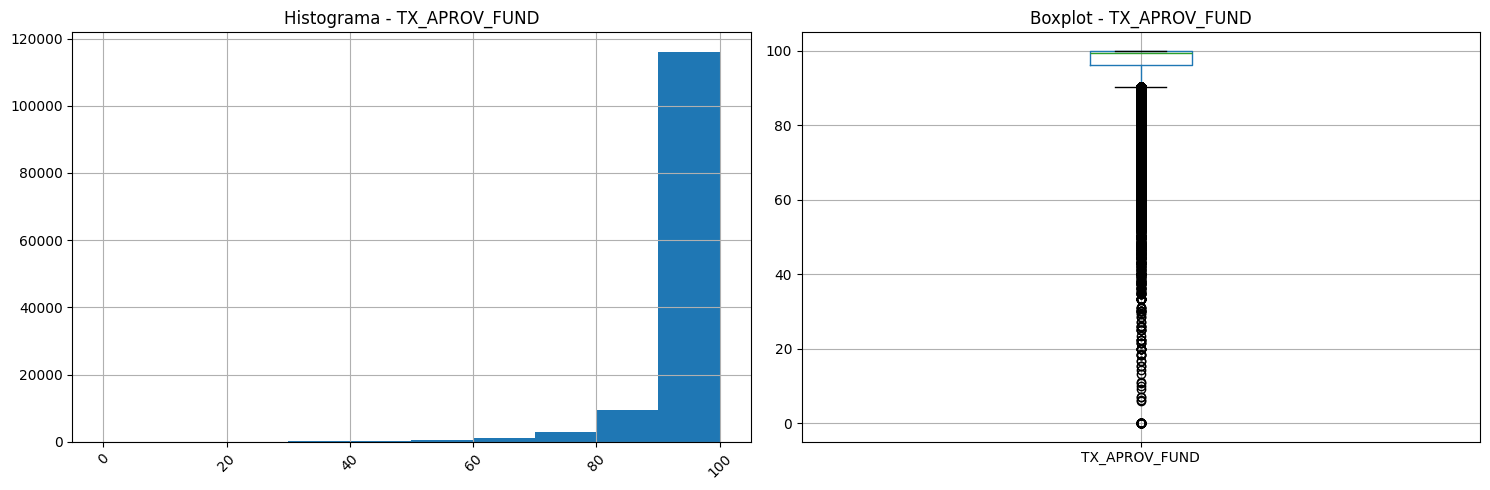

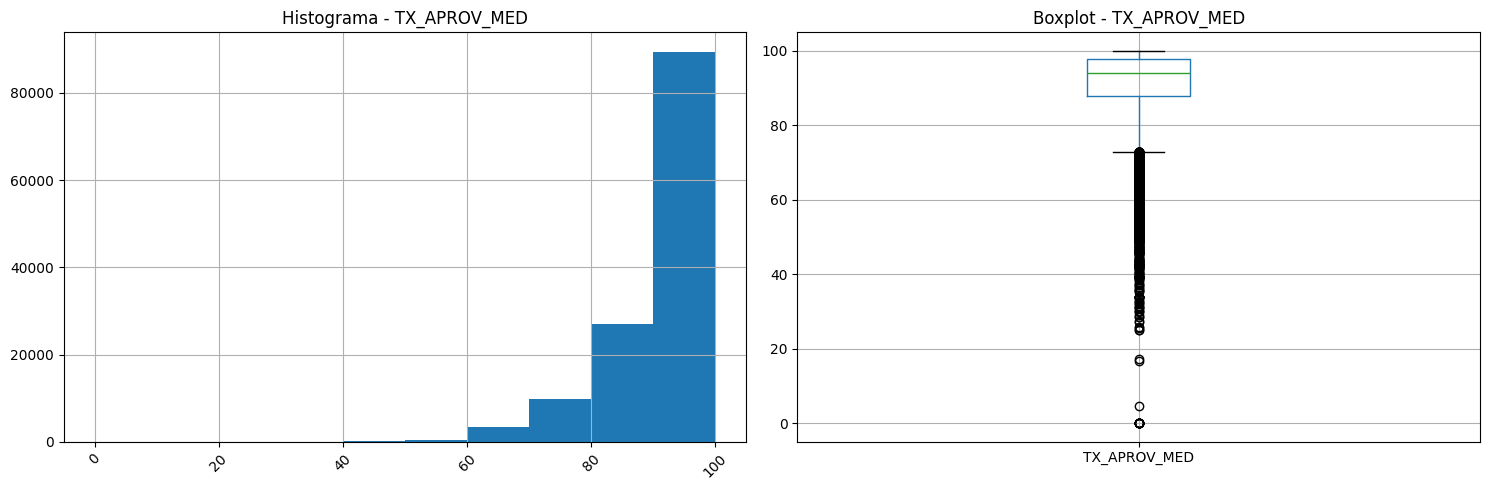

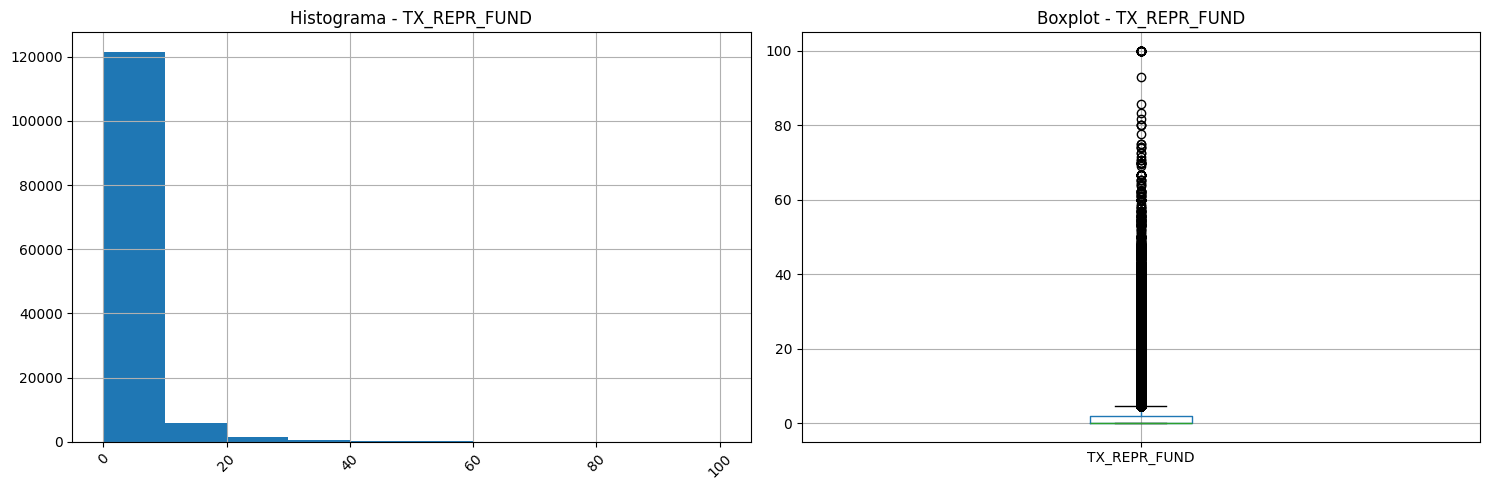

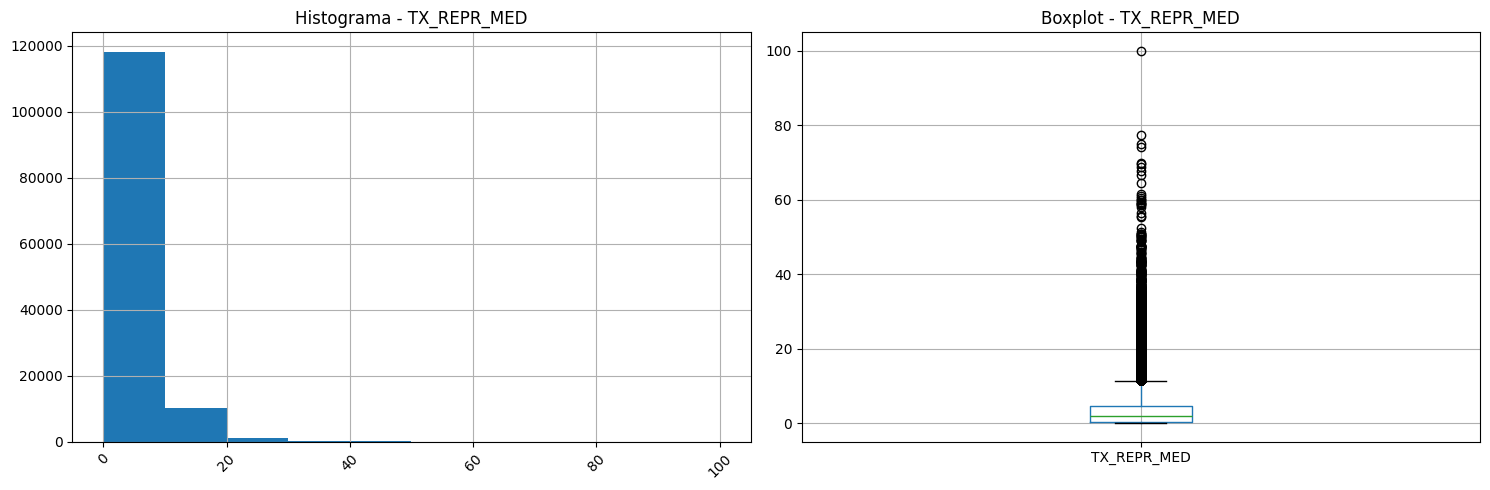

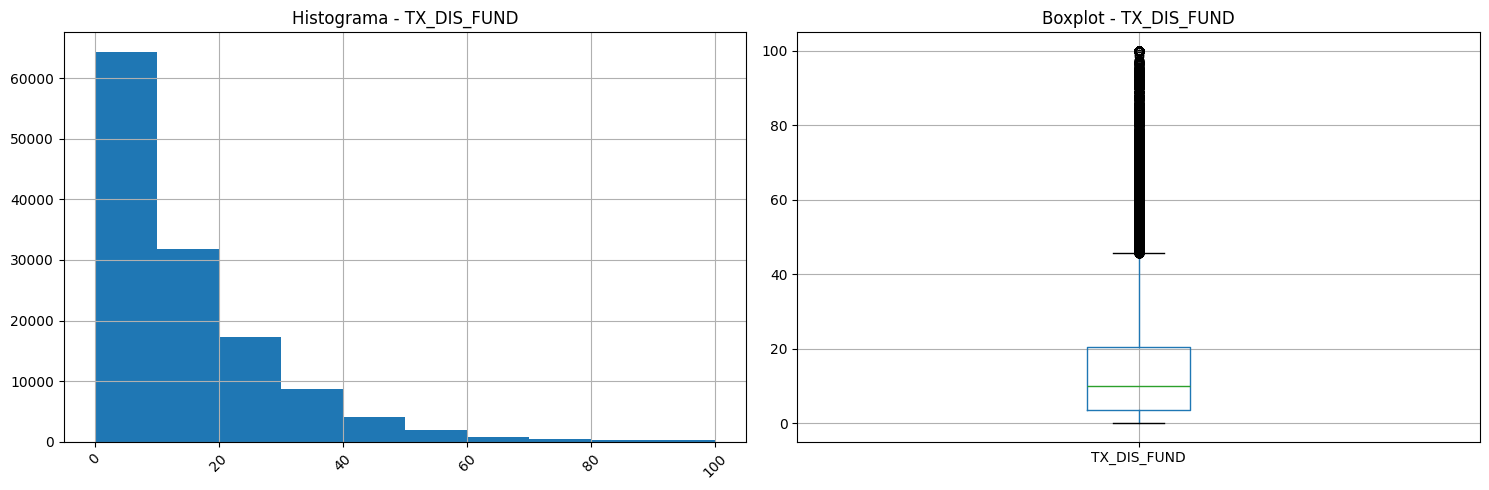

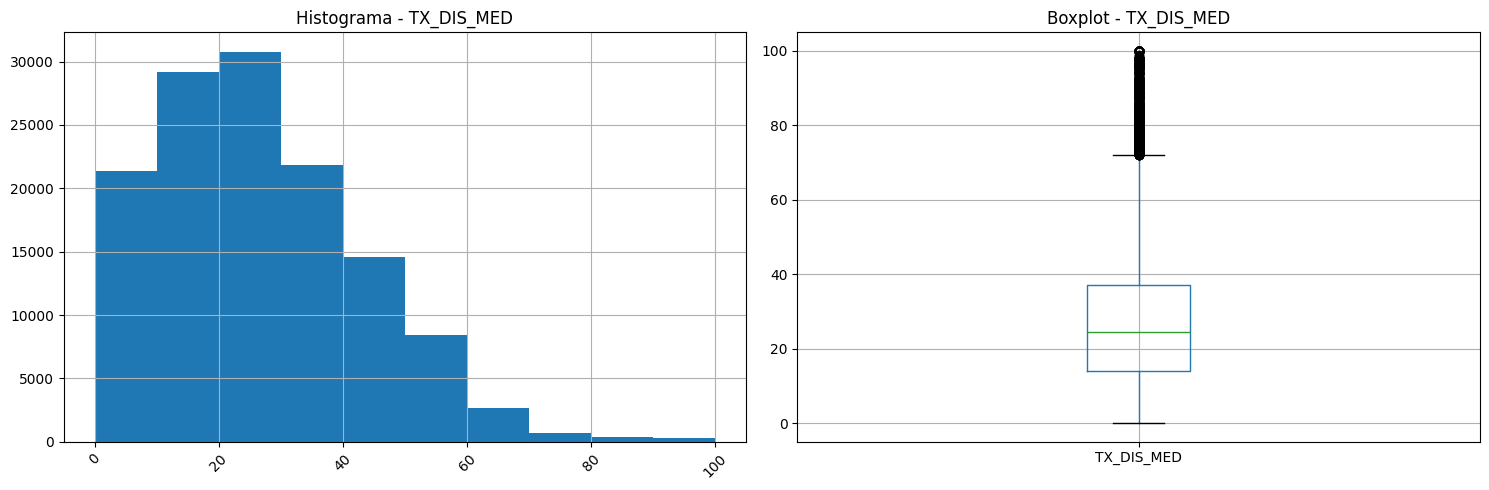

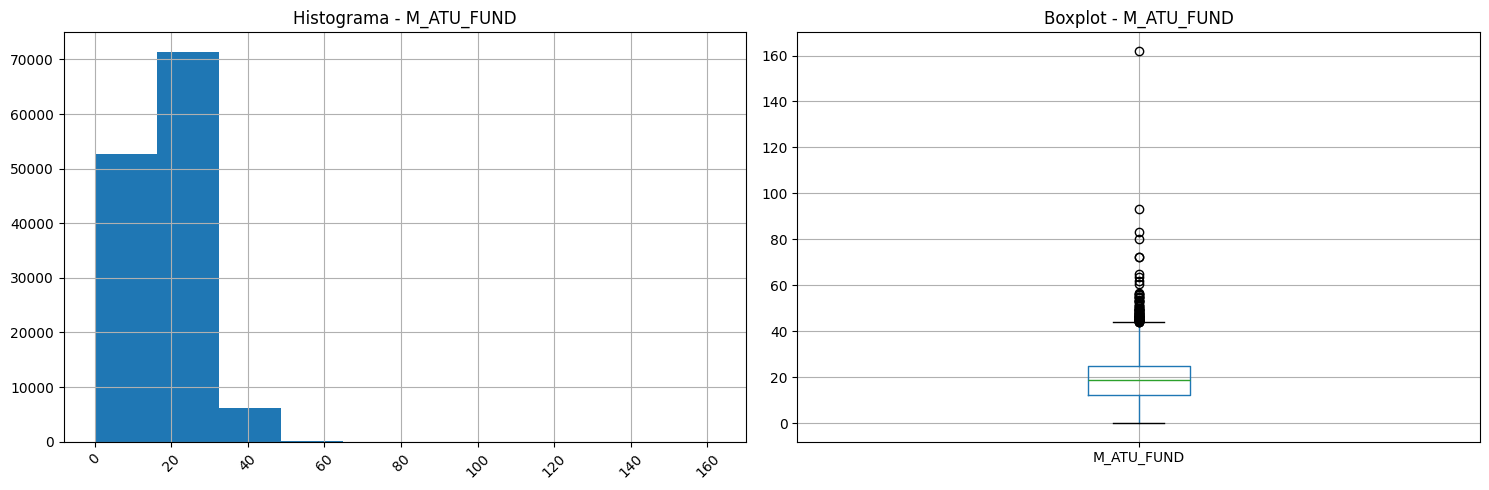

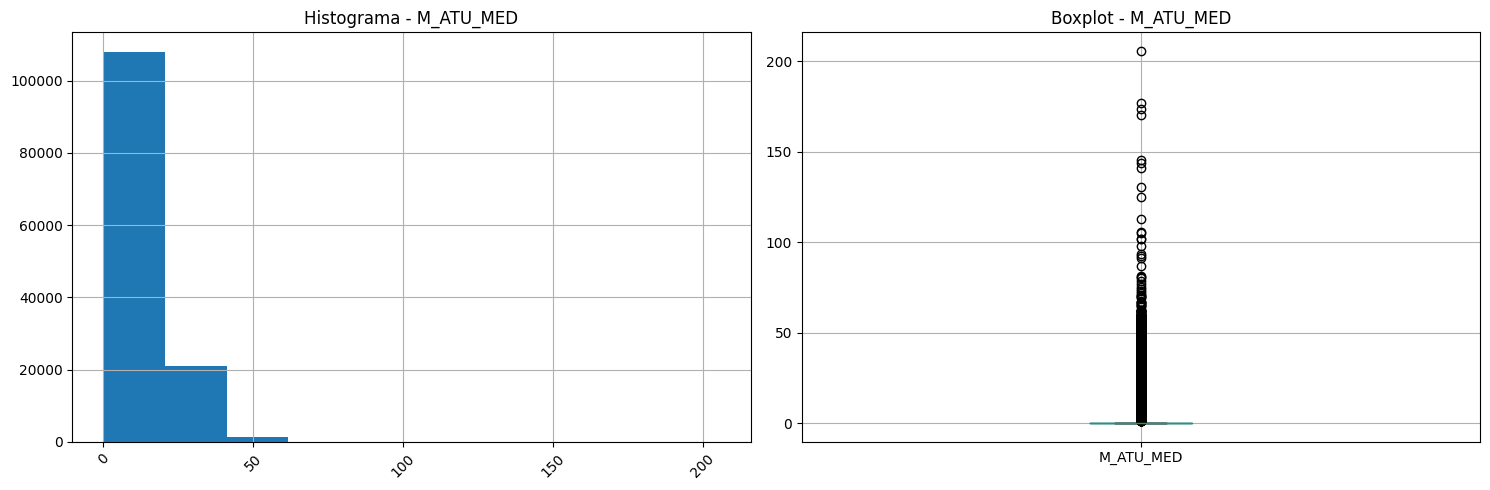

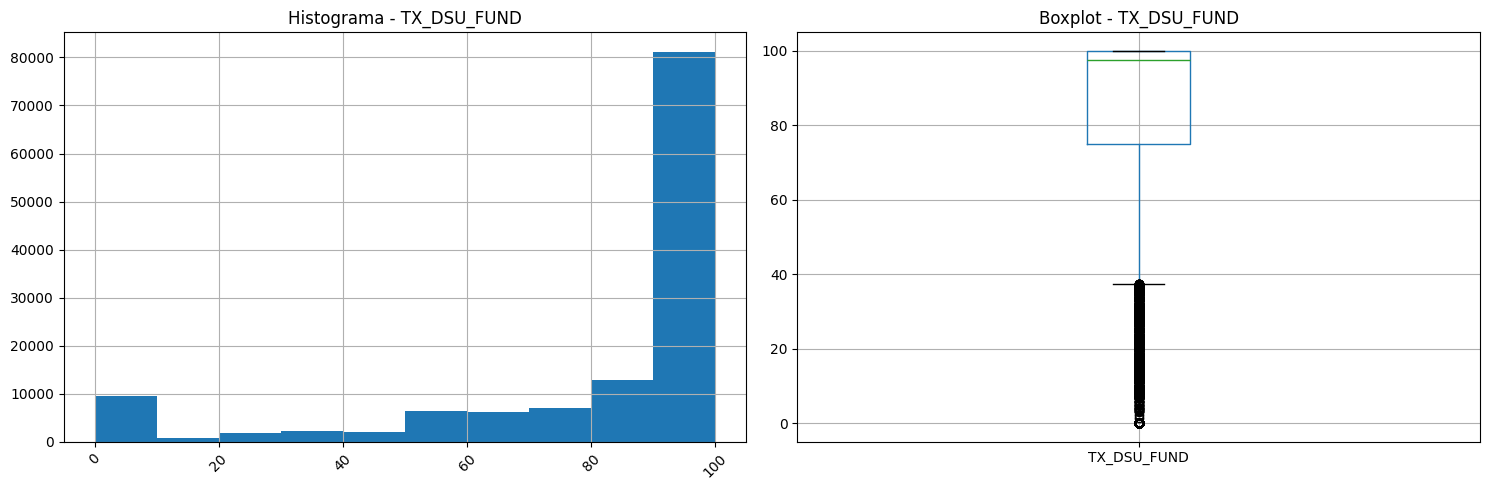

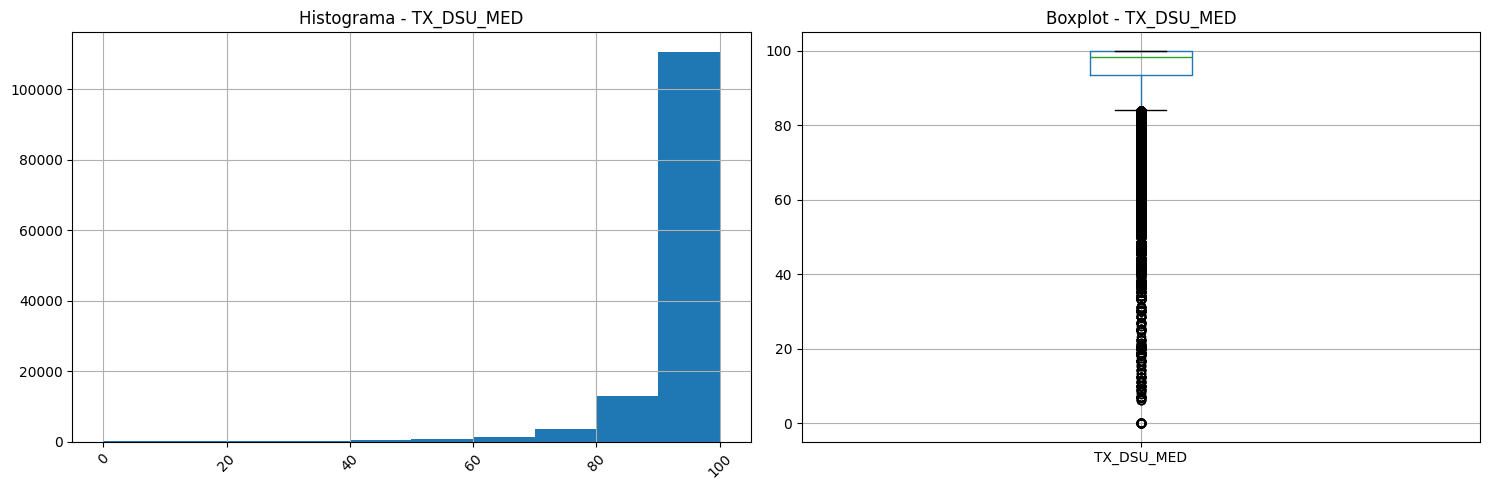

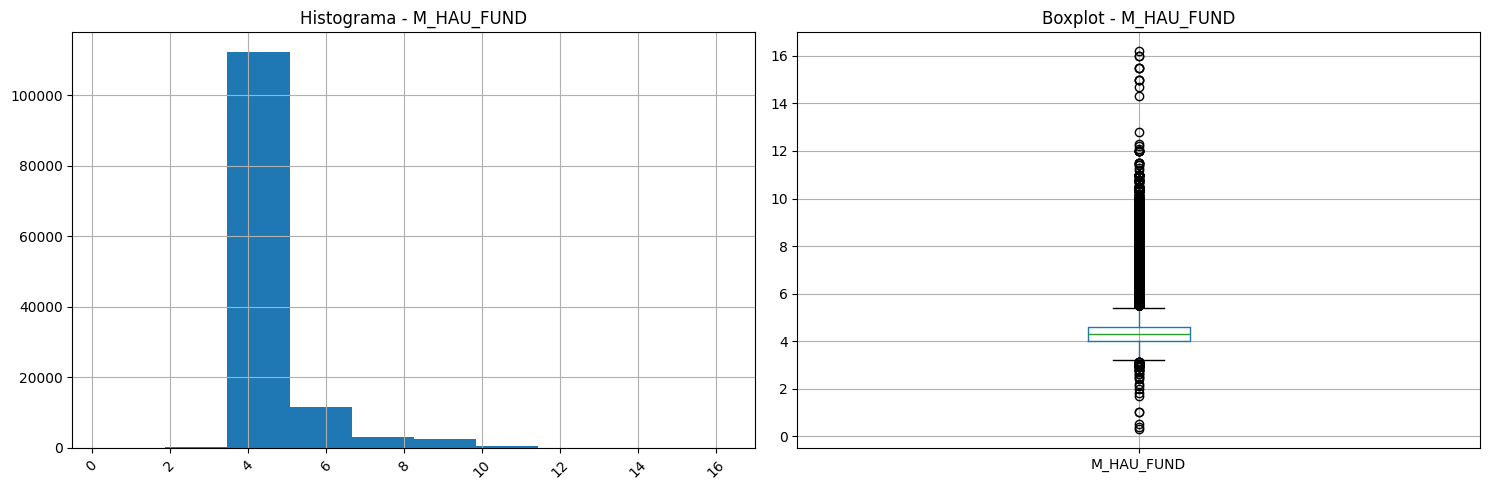

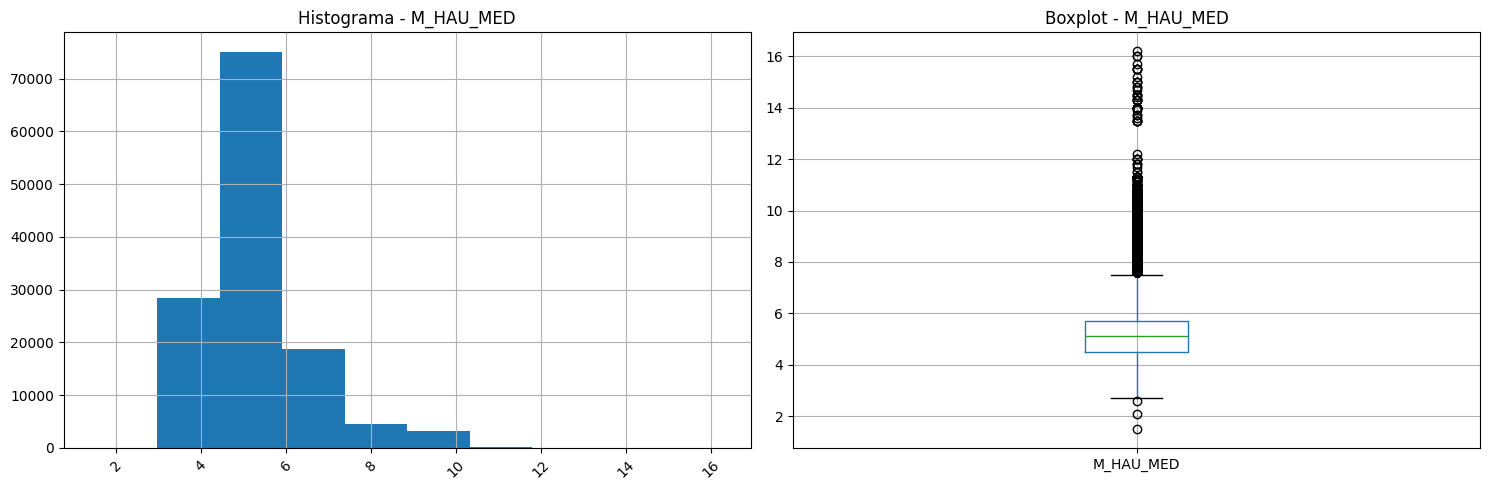

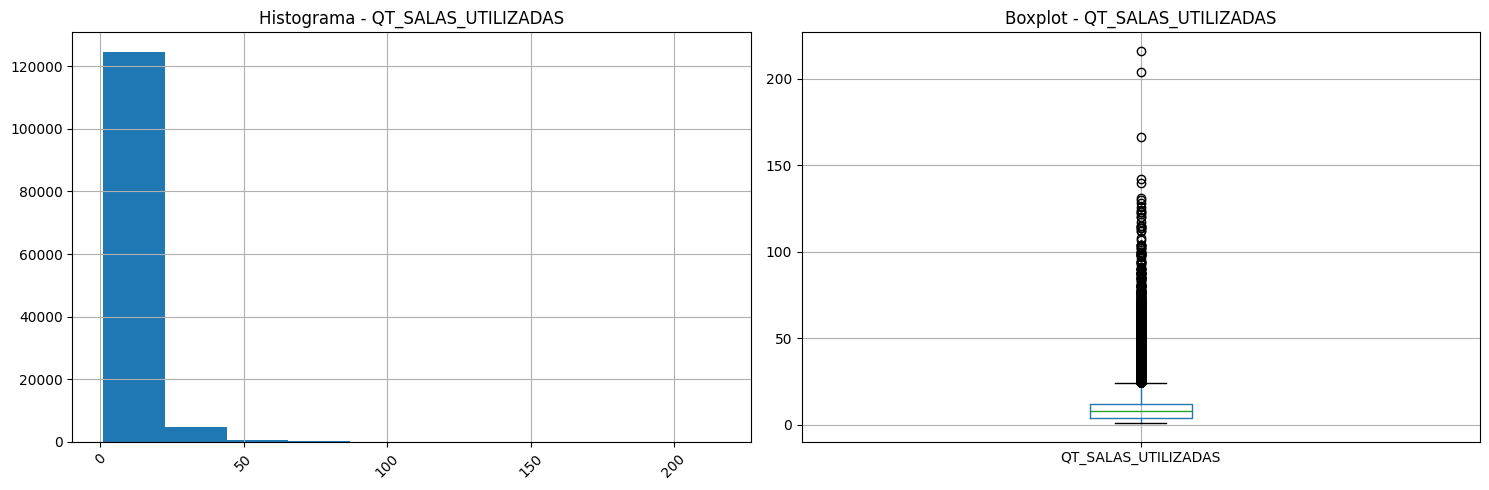

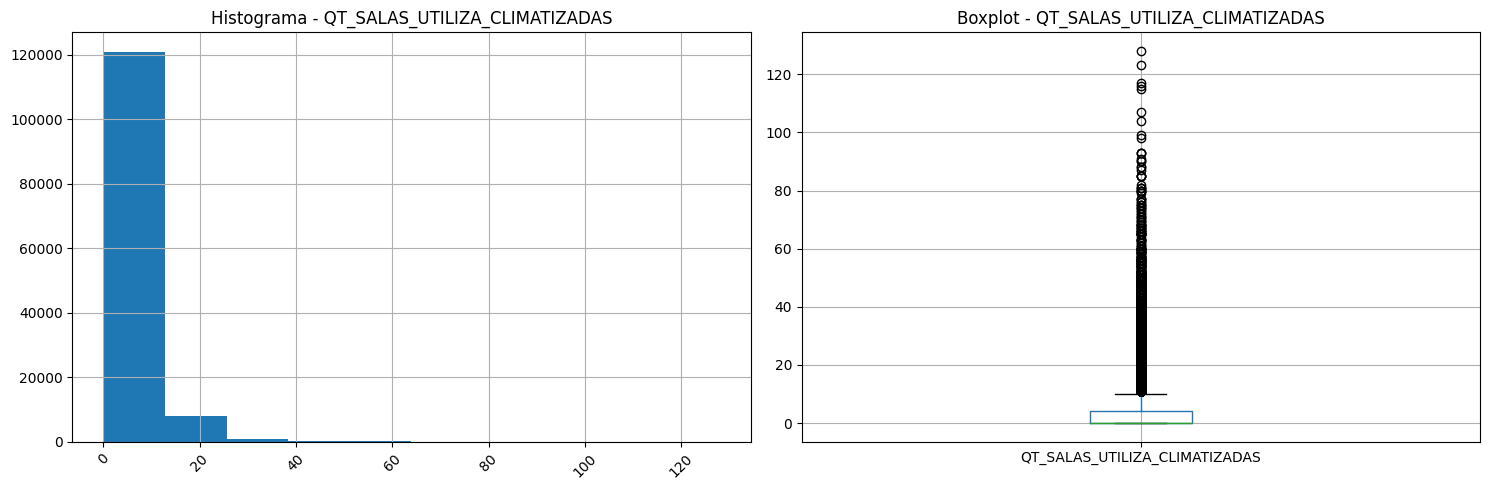

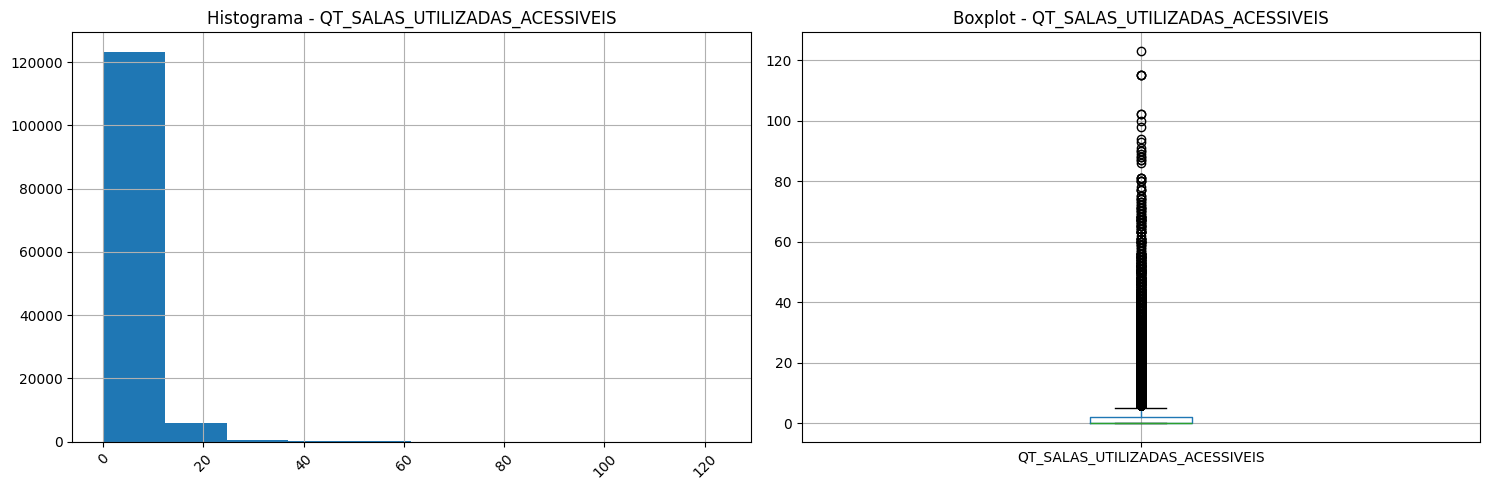

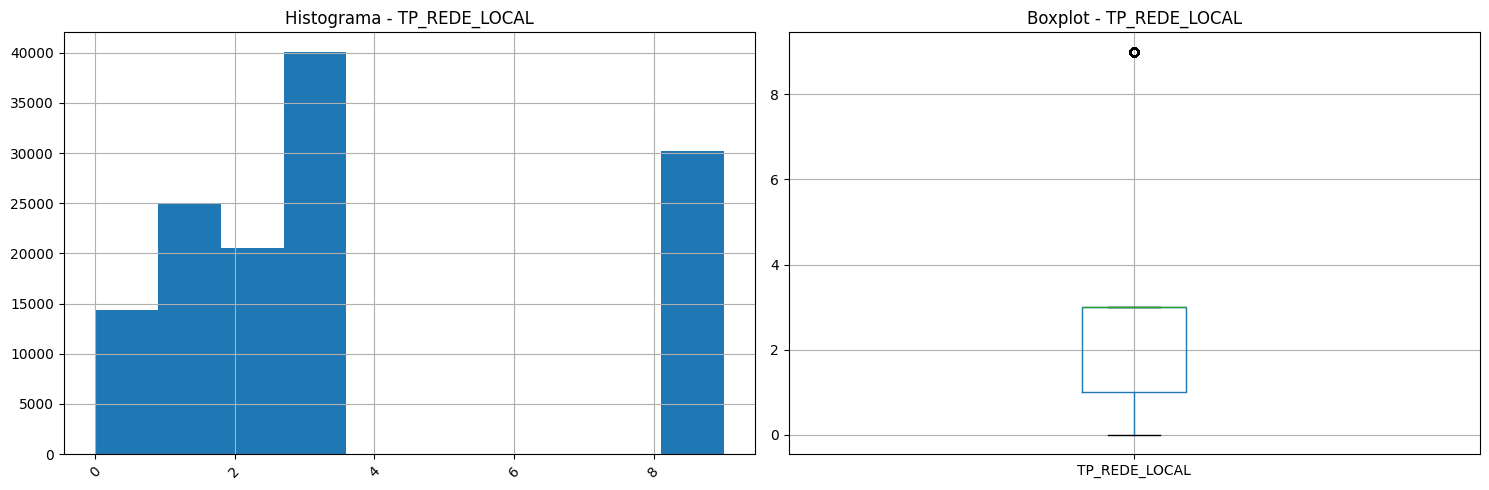

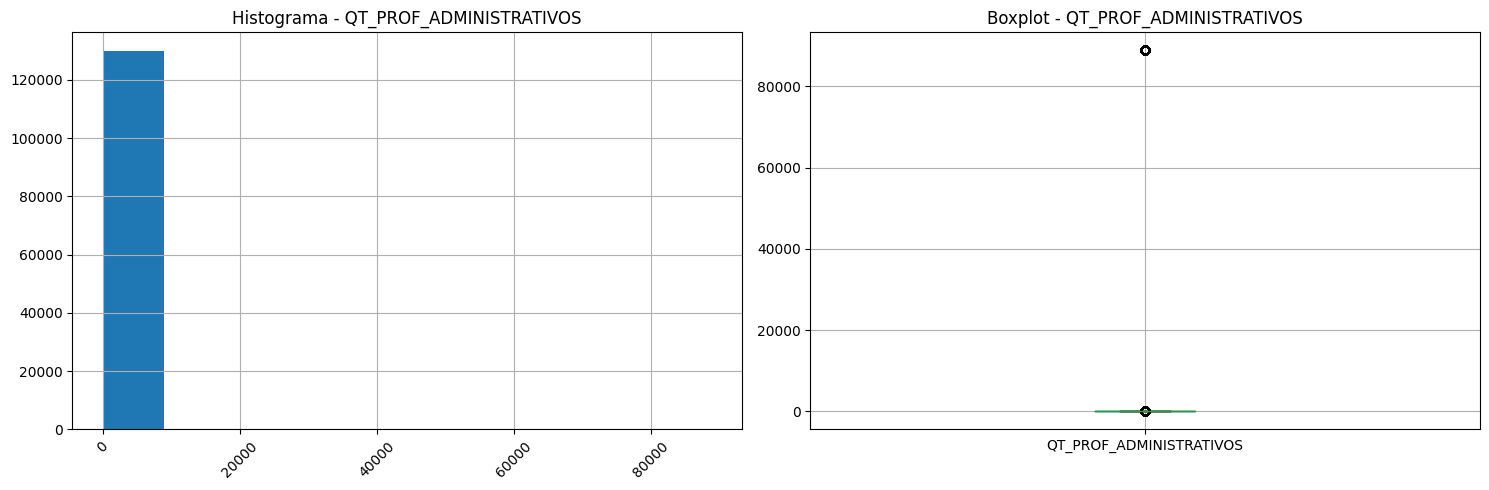

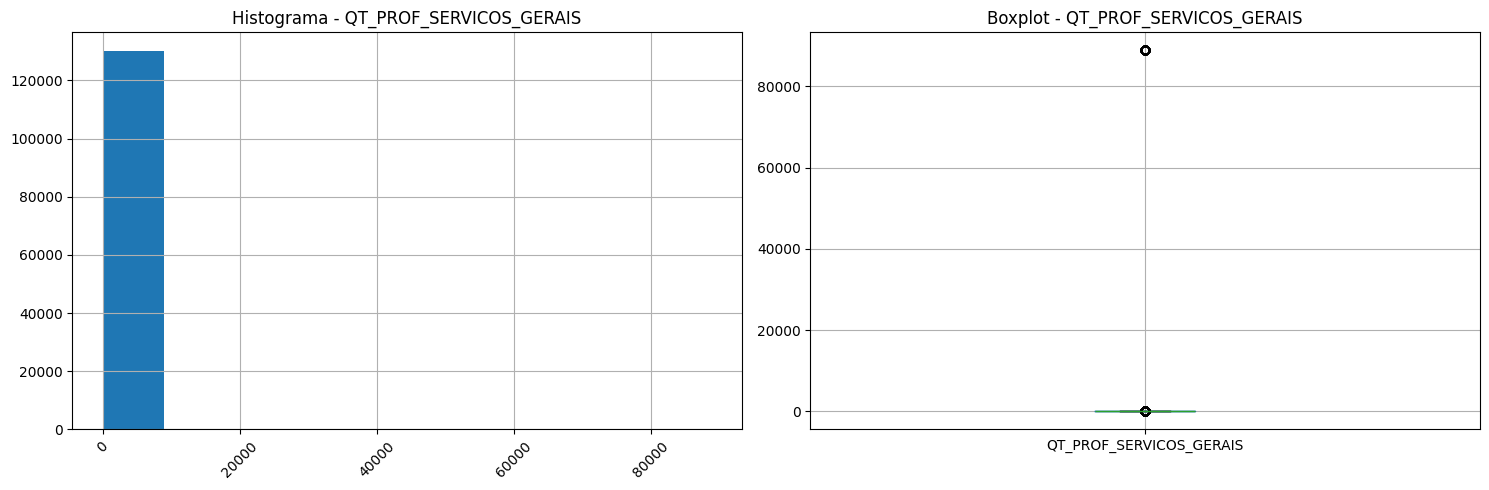

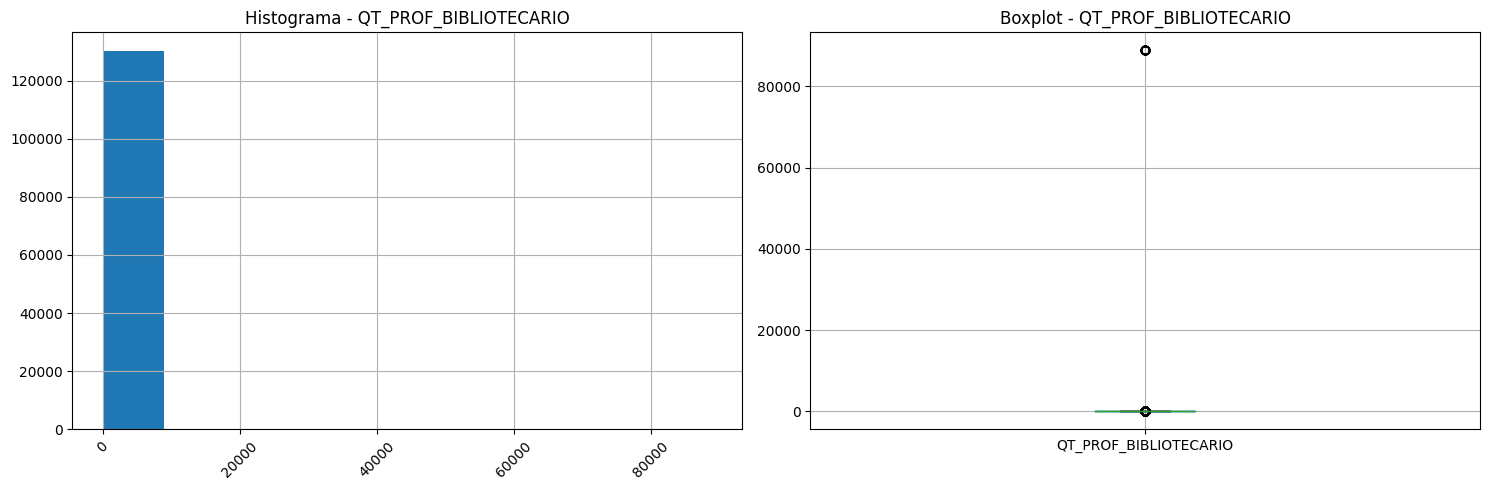

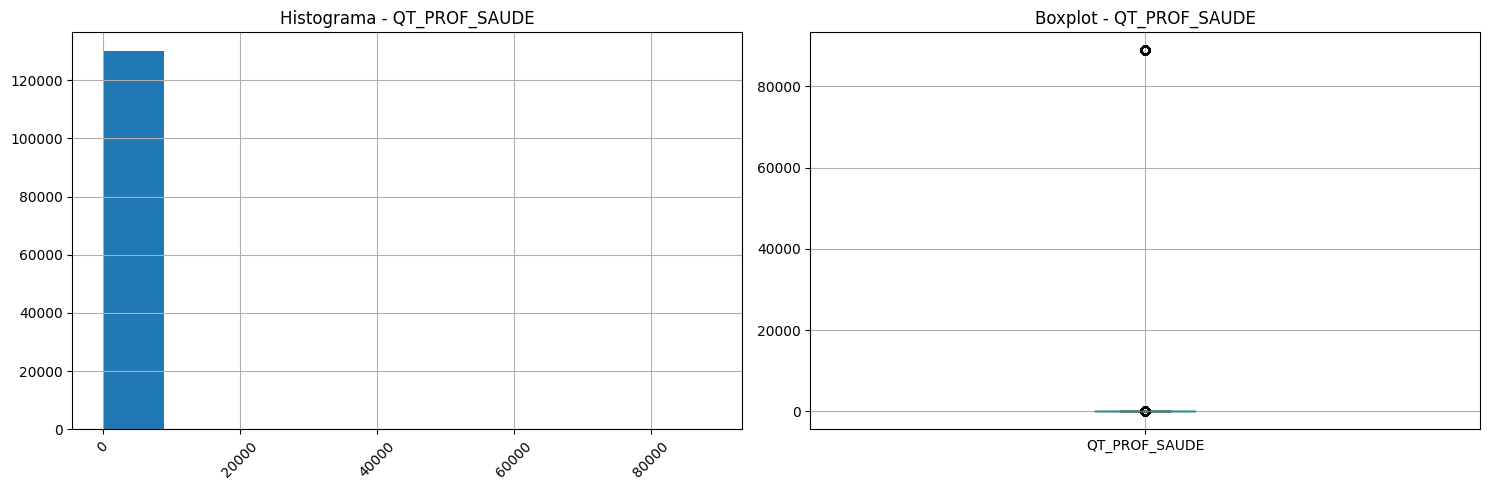

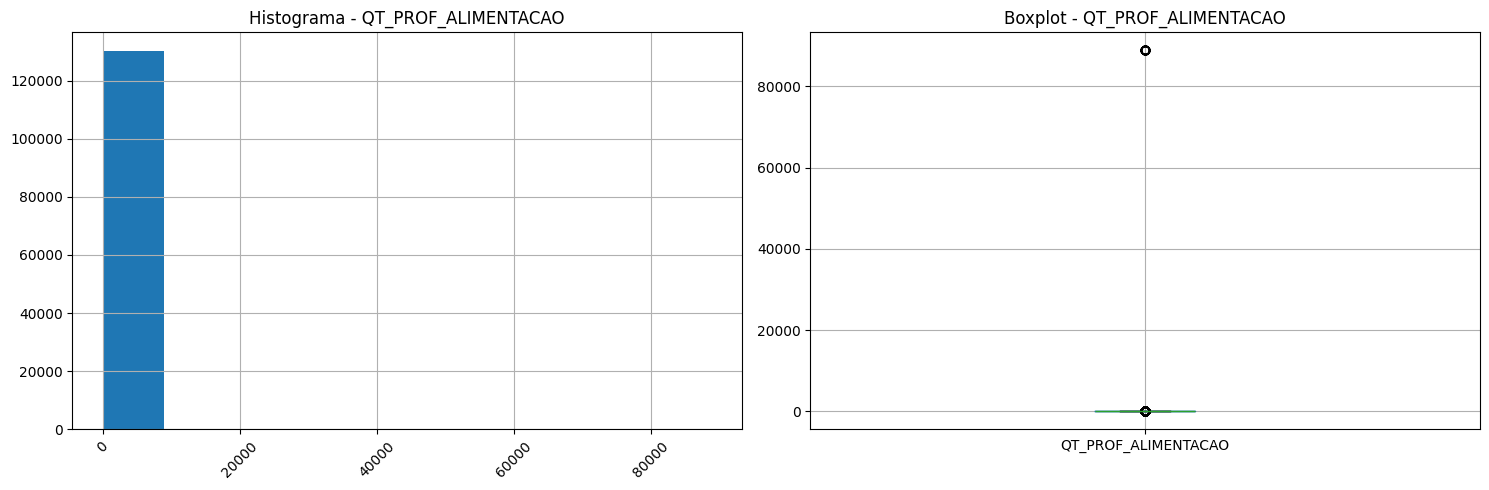

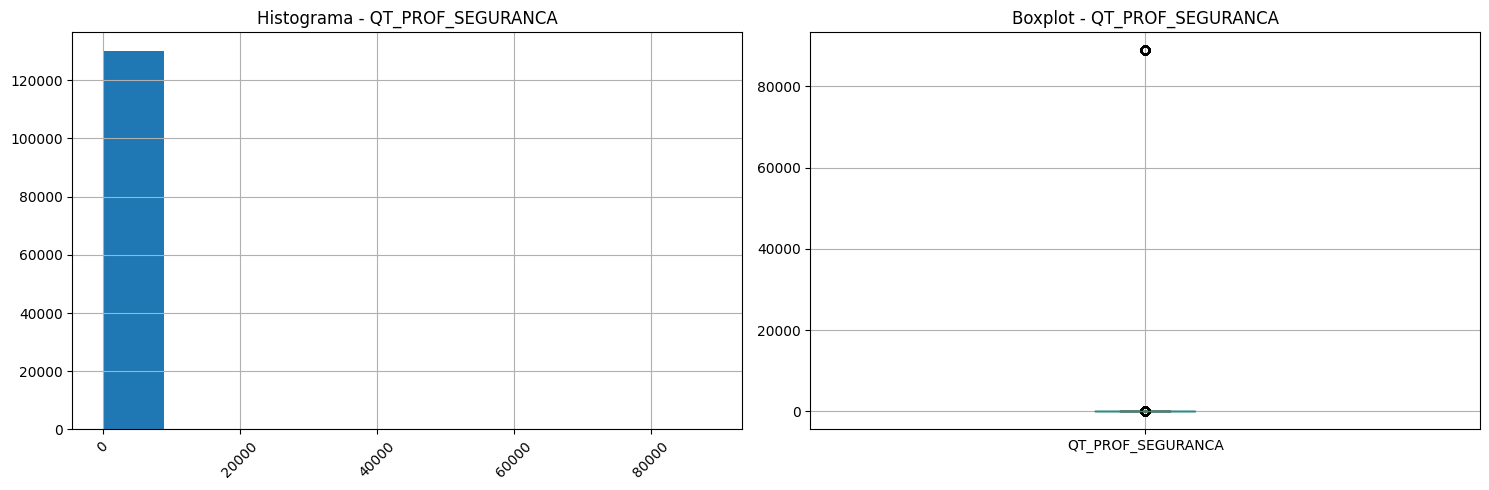

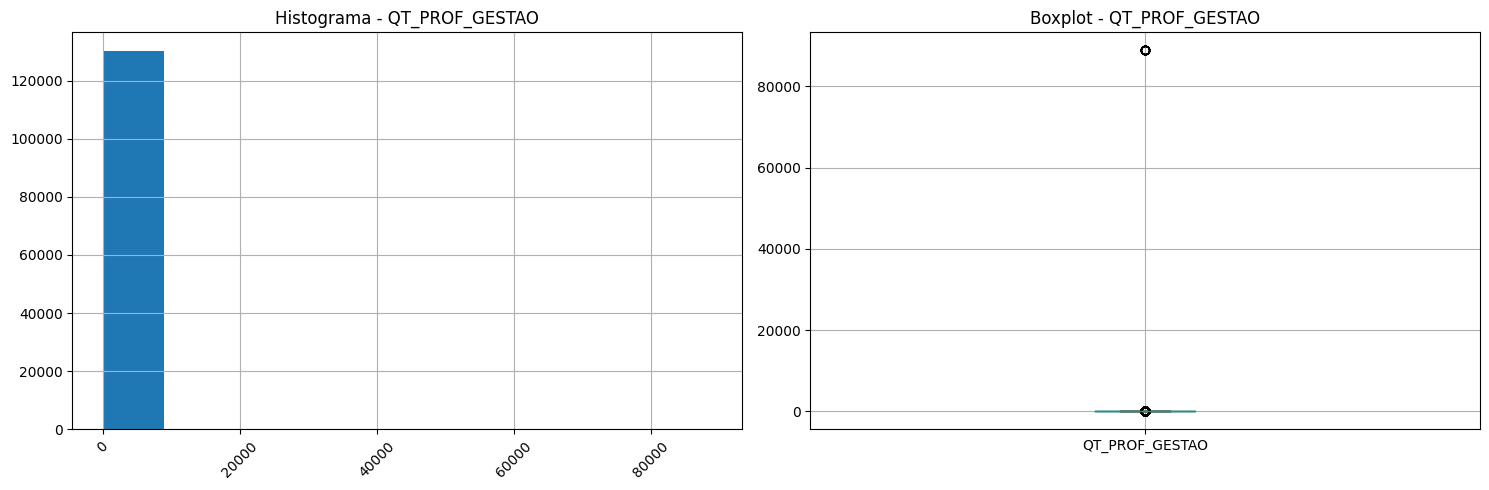

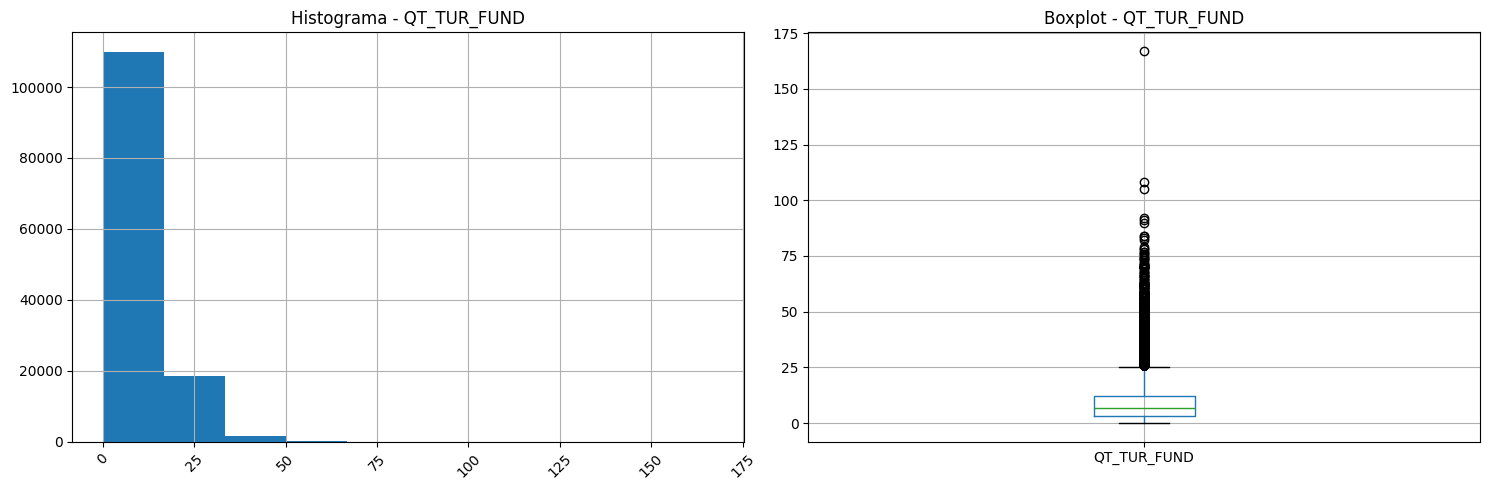

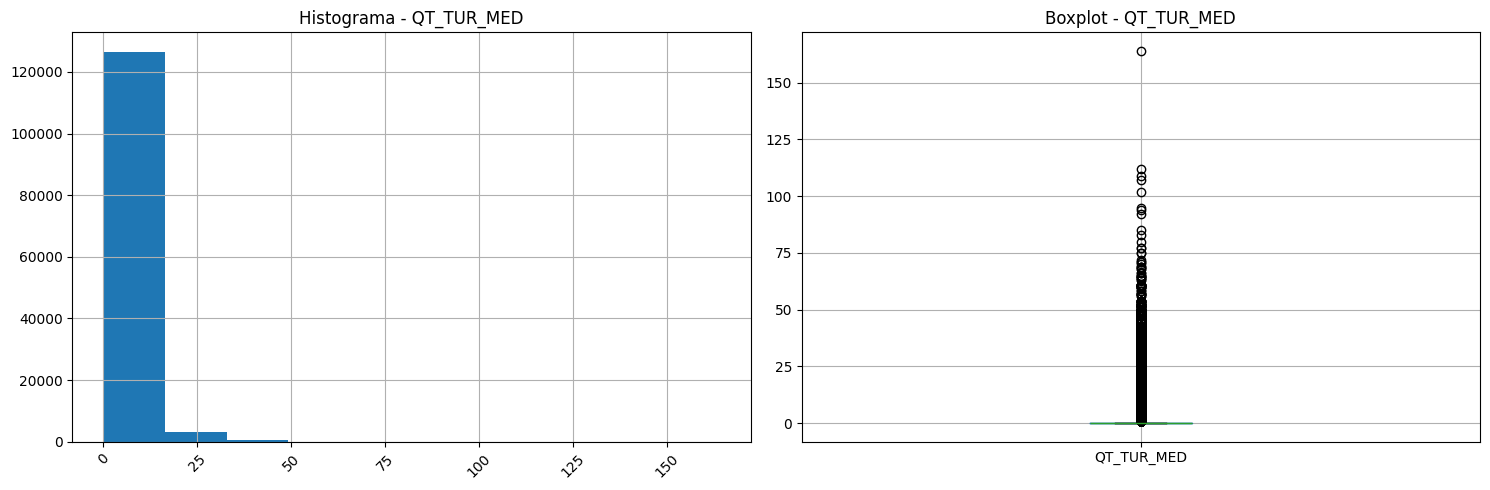

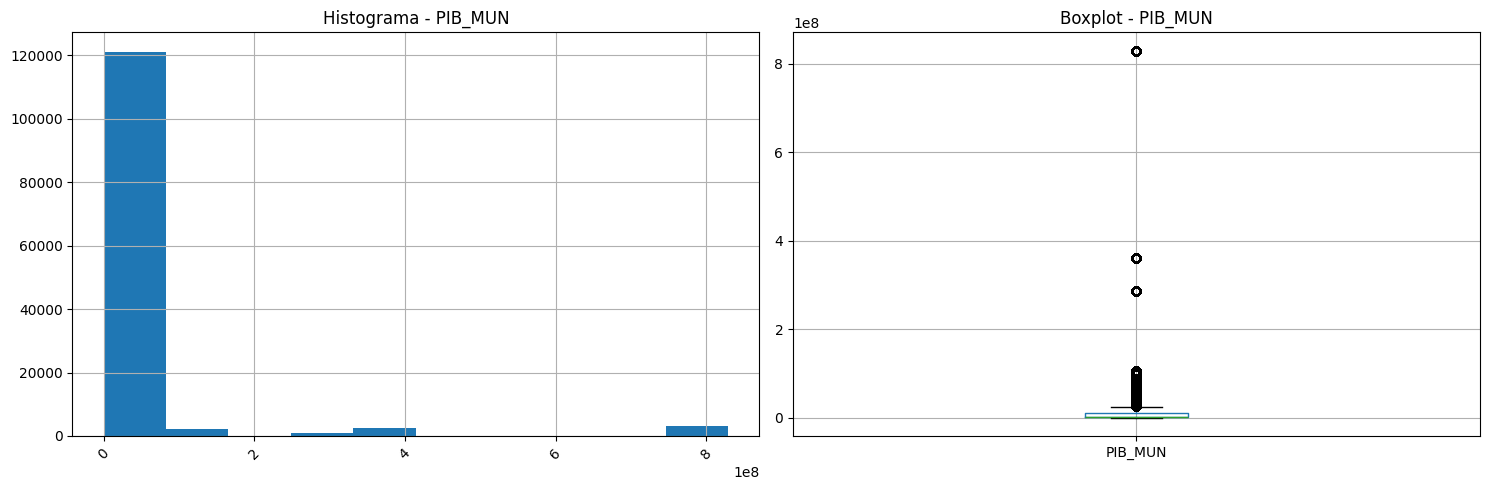

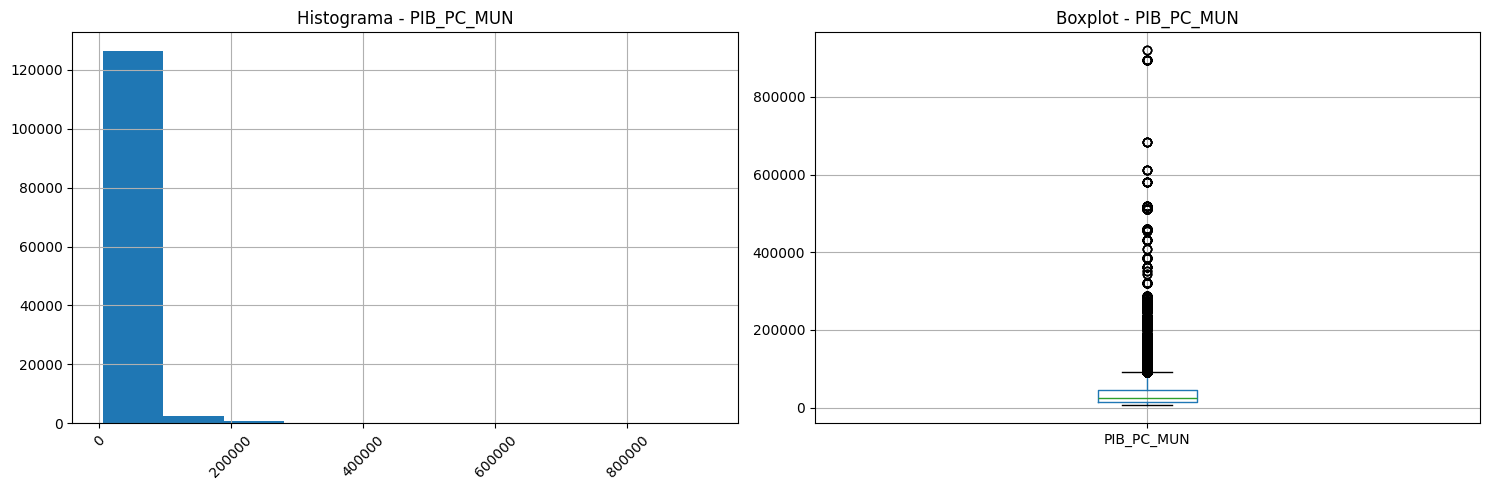

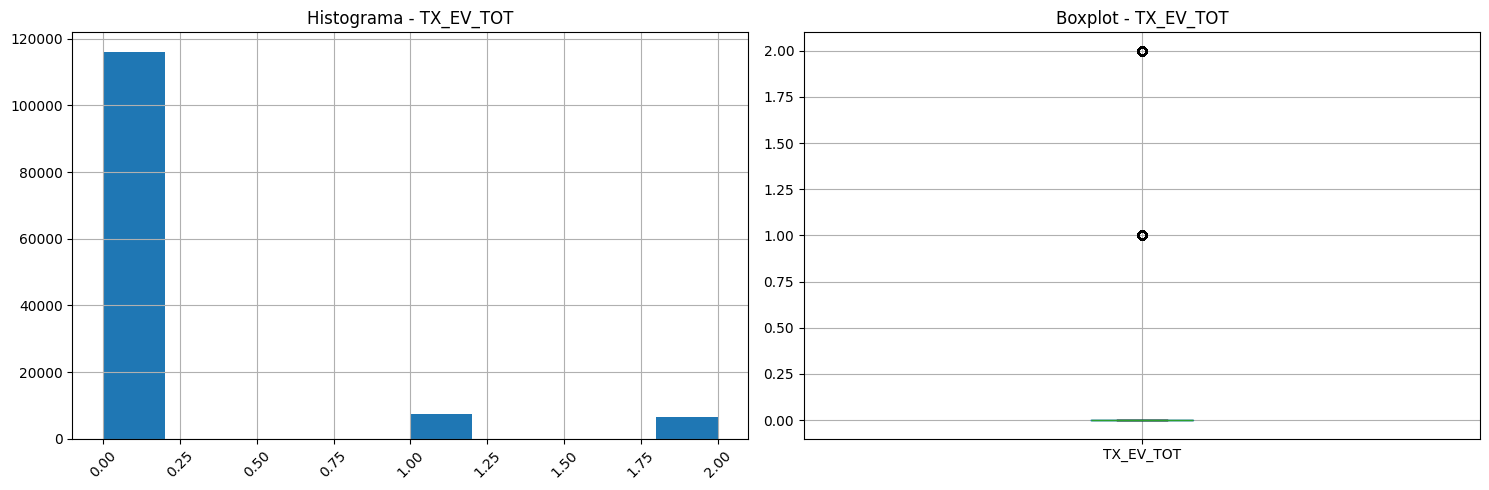

In [22]:
# # Exibe gráficos de todas as colunas não boleanas
df = df_censo_eda.select_dtypes(exclude=['bool'])
print(f'Visualizando gráficos de {len(df.columns)} colunas')
for col in df.columns:
  exibe_graficos_coluna(df, col)

Detecção de outliers

Comparação com estatísticas descritivas:

Descrição do DataFrame:
       TX_APROV_FUND   TX_APROV_MED   TX_REPR_FUND    TX_REPR_MED  \
count  130129.000000  130129.000000  130129.000000  130129.000000   
mean       96.413265      91.525948       2.233555       3.470273   
std         7.268577       8.574392       5.562855       4.793156   
min         0.000000       0.000000       0.000000       0.000000   
25%        96.100000      87.900000       0.000000       0.200000   
50%        99.400000      94.100000       0.000000       1.800000   
75%       100.000000      97.900000       1.800000       4.700000   
max       100.000000     100.000000     100.000000     100.000000   

         TX_DIS_FUND     TX_DIS_MED     M_ATU_FUND      M_ATU_MED  \
count  130129.000000  130129.000000  130129.000000  130129.000000   
mean       14.206139      26.584138      18.203997       6.081757   
std        14.482872      16.363533       9.038688      12.243515   
min         0.000000       0.000000 

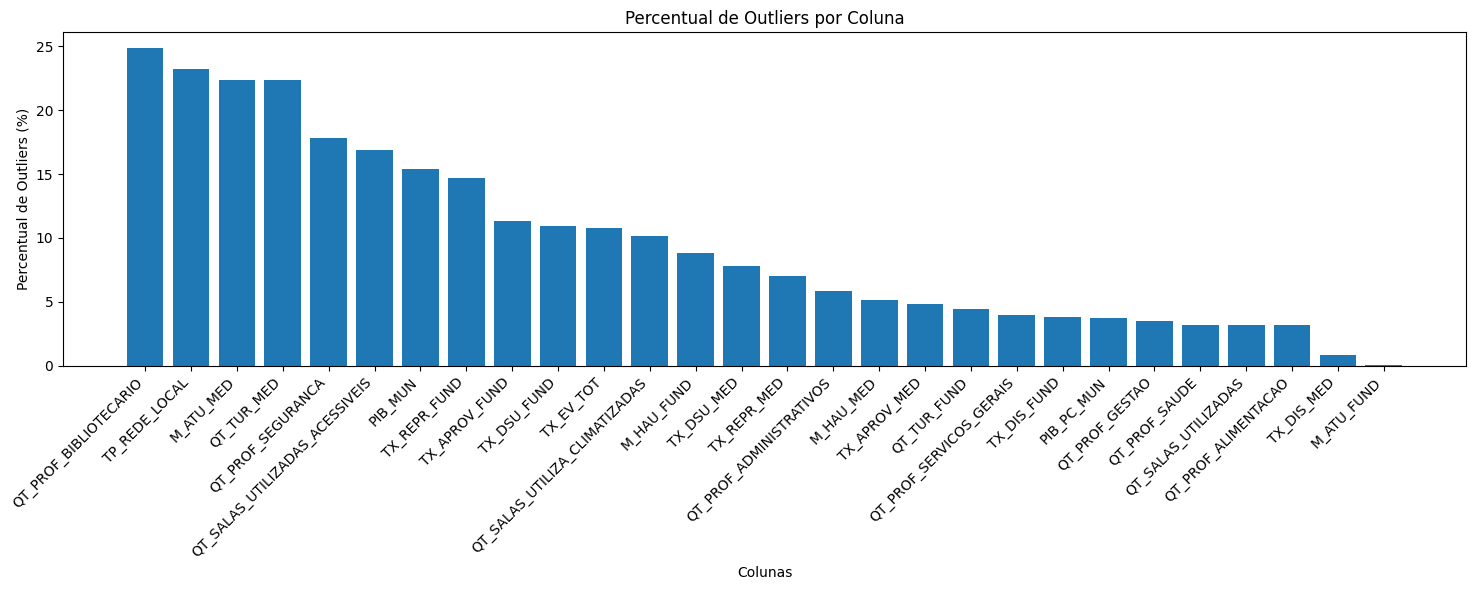

In [23]:
# Visualiza um panorama geral dos outliers de todas as colunas
resultado_outliers = analise_outliers(df_censo_eda)

# Exibir o resultado
print("\nResumo dos Outliers por Coluna:")
print("--------------------------------")
print(resultado_outliers)

# Criar um gráfico de barras para visualizar o percentual de outliers
plt.figure(figsize=(15, 6))
plt.bar(resultado_outliers['Coluna'], resultado_outliers['Percentual_Outliers'])
plt.xticks(rotation=45, ha='right')
plt.title('Percentual de Outliers por Coluna')
plt.xlabel('Colunas')
plt.ylabel('Percentual de Outliers (%)')
plt.tight_layout()
plt.show()

Tratamento de outliers

TP_REDE_LOCAL

Aproximadamente 24% dos registros da coluna de tipo de rede local são outliers com valor 9 (Não informado)
Então será alterado de 9 para 5 para manter a ordinalidade e tratar os outliers

Quantidade inicial de registros com valor 9 em TP_REDE_LOCAL: 30176
Percentual em relação ao total do dataset: 23.19%


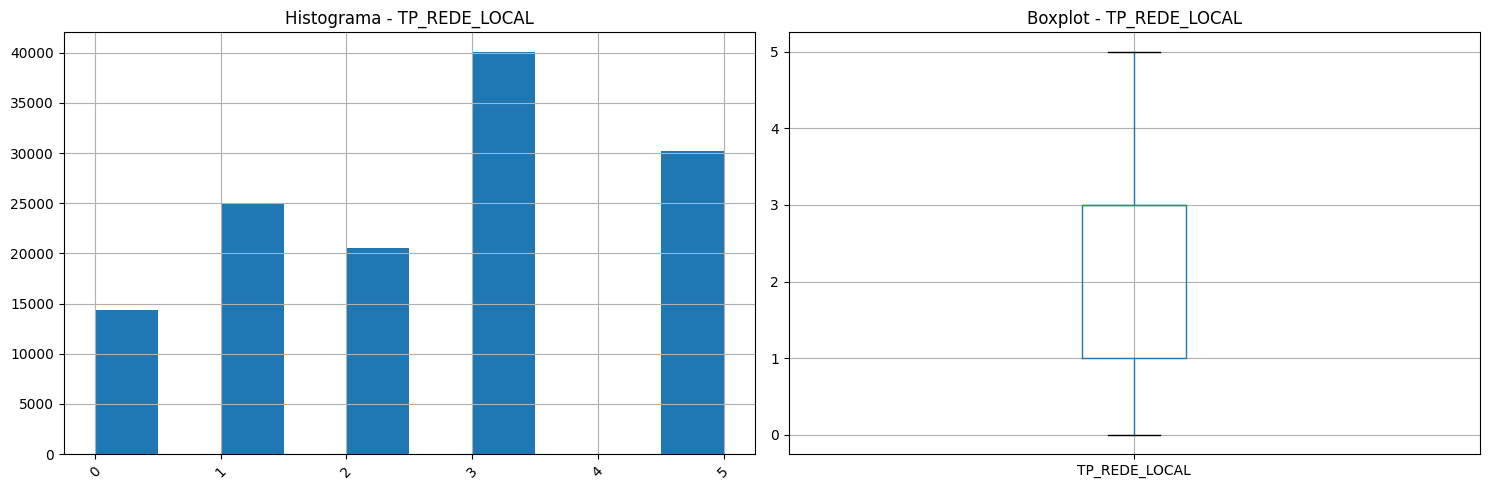

In [24]:
# Verificar a quantidade inicial de registros com valor 9
registros_rede_local_9 = df_censo_eda[df_censo_eda['TP_REDE_LOCAL'] == 9]
qt_registros_rede_local_9 = len(registros_rede_local_9)

# Calcular o percentual em relação ao total
percentual = (qt_registros_rede_local_9 / len(df_censo_eda)) * 100

print("Quantidade inicial de registros com valor 9 em TP_REDE_LOCAL:", qt_registros_rede_local_9)
print(f"Percentual em relação ao total do dataset: {percentual:.2f}%")

# Altera todos os registros de tipo de rede local igual a 9 para 5
df_censo_eda.loc[df_censo_eda['TP_REDE_LOCAL'] == 9, 'TP_REDE_LOCAL'] = 5

exibe_graficos_coluna(df_censo_eda, 'TP_REDE_LOCAL')

In [25]:
# Exibir o resultado
print("\nResumo dos Outliers por Coluna:")
print("--------------------------------")
print(analise_outliers(df_censo_eda))


Resumo dos Outliers por Coluna:
--------------------------------
Comparação com estatísticas descritivas:

Descrição do DataFrame:
       TX_APROV_FUND   TX_APROV_MED   TX_REPR_FUND    TX_REPR_MED  \
count  130129.000000  130129.000000  130129.000000  130129.000000   
mean       96.413265      91.525948       2.233555       3.470273   
std         7.268577       8.574392       5.562855       4.793156   
min         0.000000       0.000000       0.000000       0.000000   
25%        96.100000      87.900000       0.000000       0.200000   
50%        99.400000      94.100000       0.000000       1.800000   
75%       100.000000      97.900000       1.800000       4.700000   
max       100.000000     100.000000     100.000000     100.000000   

         TX_DIS_FUND     TX_DIS_MED     M_ATU_FUND      M_ATU_MED  \
count  130129.000000  130129.000000  130129.000000  130129.000000   
mean       14.206139      26.584138      18.203997       6.081757   
std        14.482872      16.363533    

QT_PROF

Todos os QT_prof que contenham 88888 serão substituídos pelo limite superior, pois quando há o preenchimento 88888 é porque está superior ao necessário

In [26]:
# Obter lista de nomes de colunas que começam com QT_PROF
qt_prof_cols = [col for col in df_censo_eda.columns if col.startswith('QT_PROF')]
for col in qt_prof_cols:
    registros_88888 = len(df_censo_eda[df_censo_eda[col] == 88888])
    print(f"Quantidade de registros na coluna {col} que é igual a 88888: {registros_88888:,}")

# Quantidade inicial de registros
total_registros = len(df_censo_eda)
# print(f"Quantidade total de registros: {total_registros:,}")

# Criar máscara para registros com 88888 em qualquer uma das colunas
registros_afetados = df_censo_eda[qt_prof_cols].eq(88888).any(axis=1)

# Contar registros afetados
total_afetados = registros_afetados.sum()
percentual = (total_afetados / total_registros) * 100

print(f"\nQuantidade de linhas com ao menos uma coluna igual a 88888: {total_afetados:,}")
print(f"Percentual do total: {percentual:.2f}%")


Quantidade de registros na coluna QT_PROF_ADMINISTRATIVOS que é igual a 88888: 292
Quantidade de registros na coluna QT_PROF_SERVICOS_GERAIS que é igual a 88888: 125
Quantidade de registros na coluna QT_PROF_BIBLIOTECARIO que é igual a 88888: 35
Quantidade de registros na coluna QT_PROF_SAUDE que é igual a 88888: 222
Quantidade de registros na coluna QT_PROF_ALIMENTACAO que é igual a 88888: 39
Quantidade de registros na coluna QT_PROF_SEGURANCA que é igual a 88888: 140
Quantidade de registros na coluna QT_PROF_GESTAO que é igual a 88888: 18

Quantidade de linhas com ao menos uma coluna igual a 88888: 815
Percentual do total: 0.63%


In [27]:
# Dado a baixa frequencia dentro da base, inferior a 1%, as linhas 88888, foram removidas.
# Remover registros com 88888 em qualquer uma das colunas qt_prof_cols
df_censo_eda = df_censo_eda[~registros_afetados]

In [28]:
# Exibir o resultado
print("\nResumo dos Outliers por Coluna:")
print("--------------------------------")
print(analise_outliers(df_censo_eda))


Resumo dos Outliers por Coluna:
--------------------------------
Comparação com estatísticas descritivas:

Descrição do DataFrame:
       TX_APROV_FUND   TX_APROV_MED   TX_REPR_FUND    TX_REPR_MED  \
count  129314.000000  129314.000000  129314.000000  129314.000000   
mean       96.407475      91.513661       2.236415       3.471699   
std         7.266941       8.574447       5.562789       4.790225   
min         0.000000       0.000000       0.000000       0.000000   
25%        96.100000      87.800000       0.000000       0.200000   
50%        99.400000      94.100000       0.000000       1.800000   
75%       100.000000      97.900000       1.800000       4.700000   
max       100.000000     100.000000     100.000000     100.000000   

         TX_DIS_FUND     TX_DIS_MED     M_ATU_FUND      M_ATU_MED  \
count  129314.000000  129314.000000  129314.000000  129314.000000   
mean       14.209263      26.583007      18.244380       6.083333   
std        14.446314      16.299785    

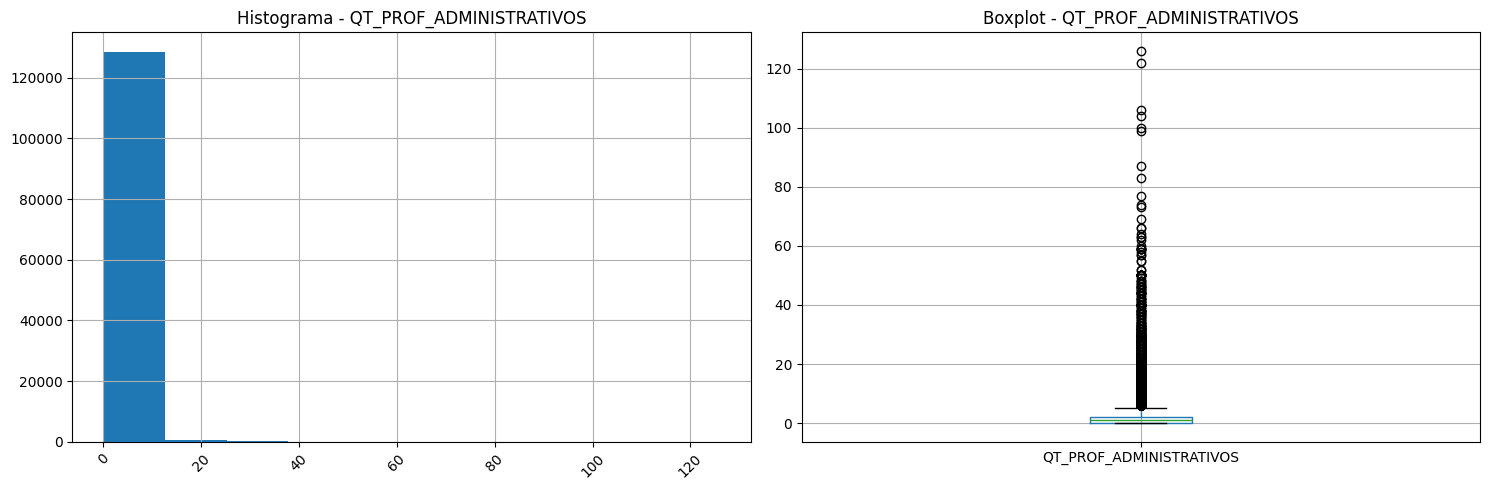

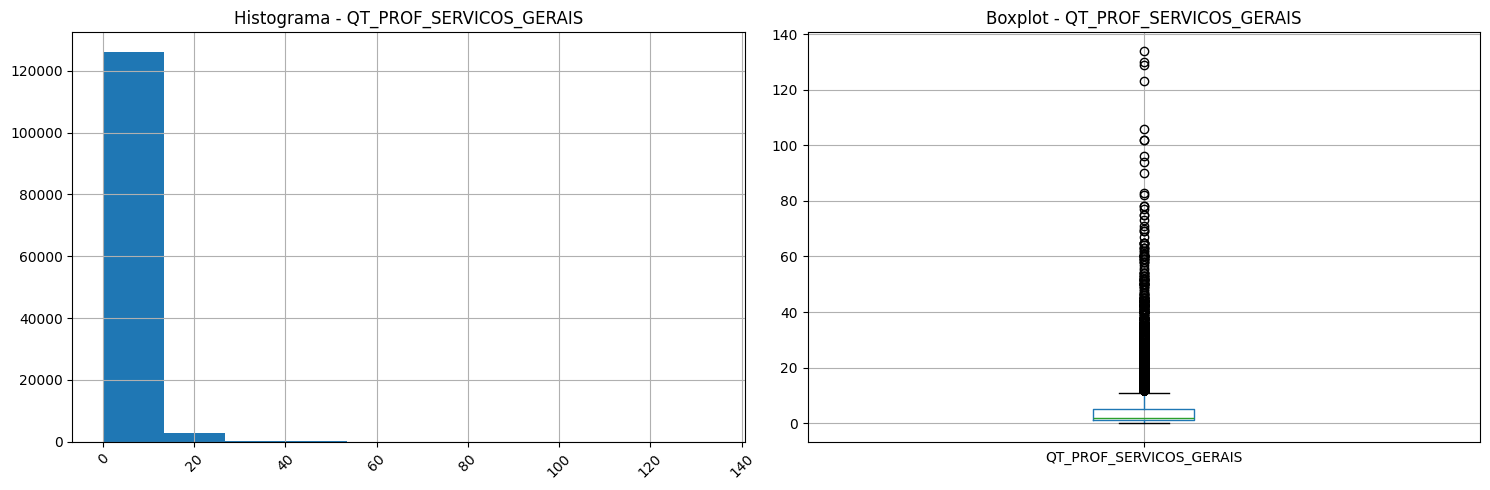

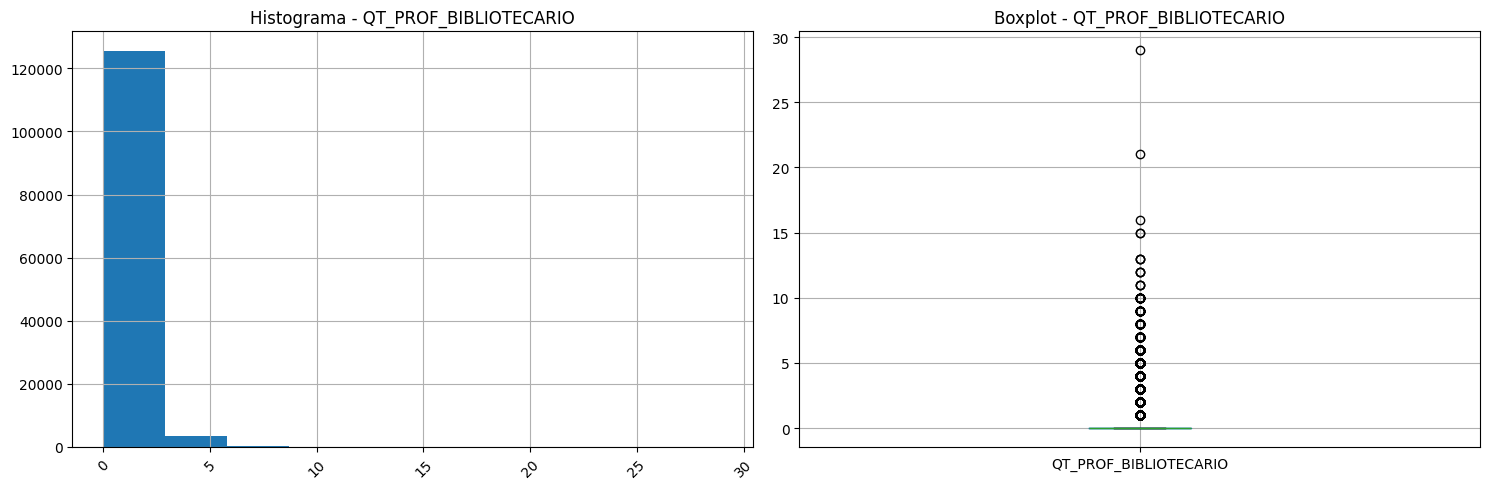

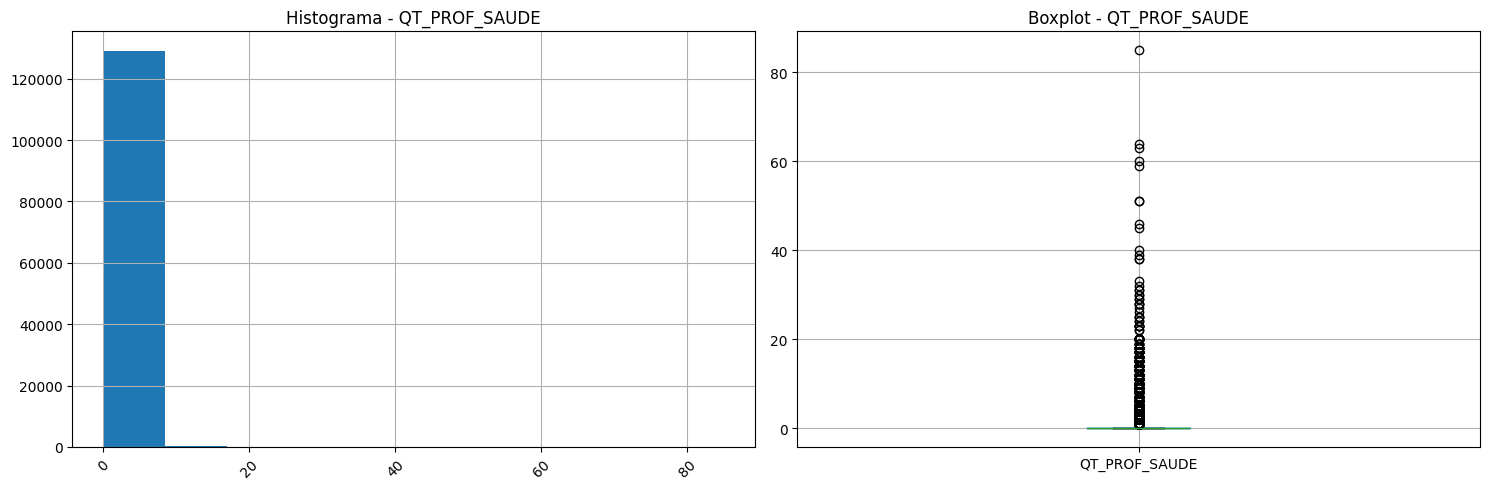

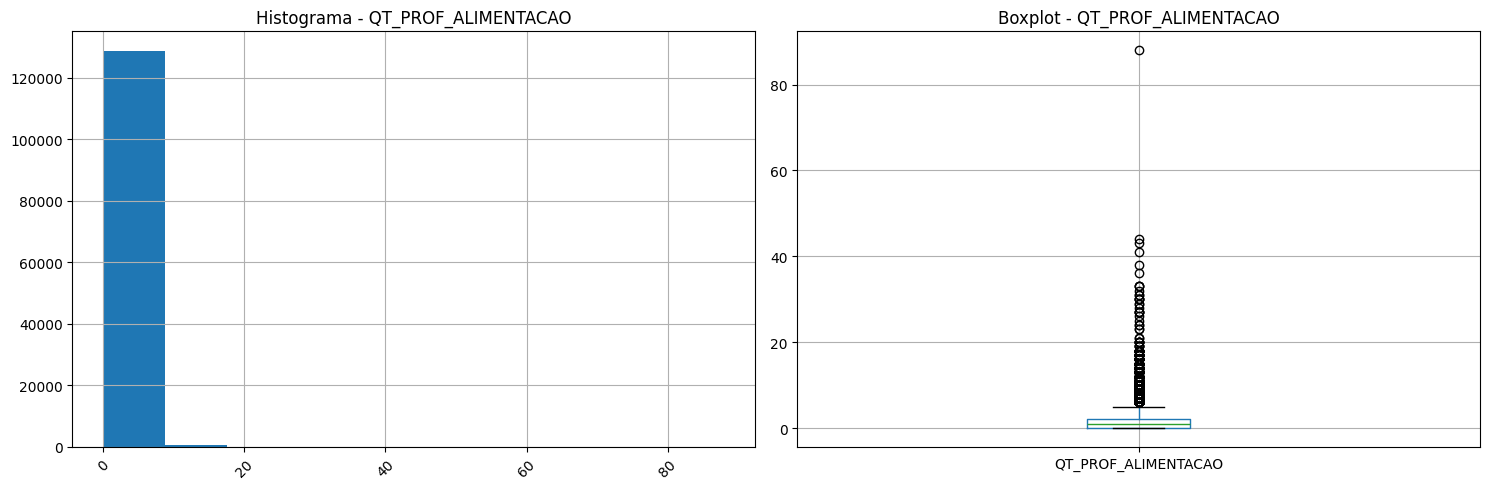

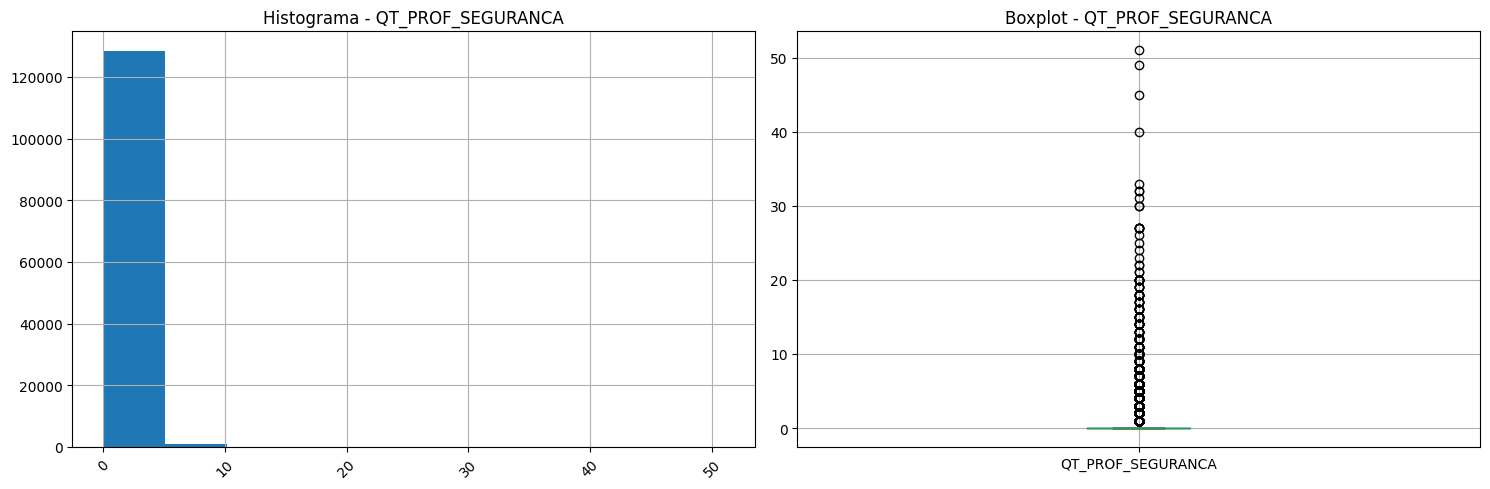

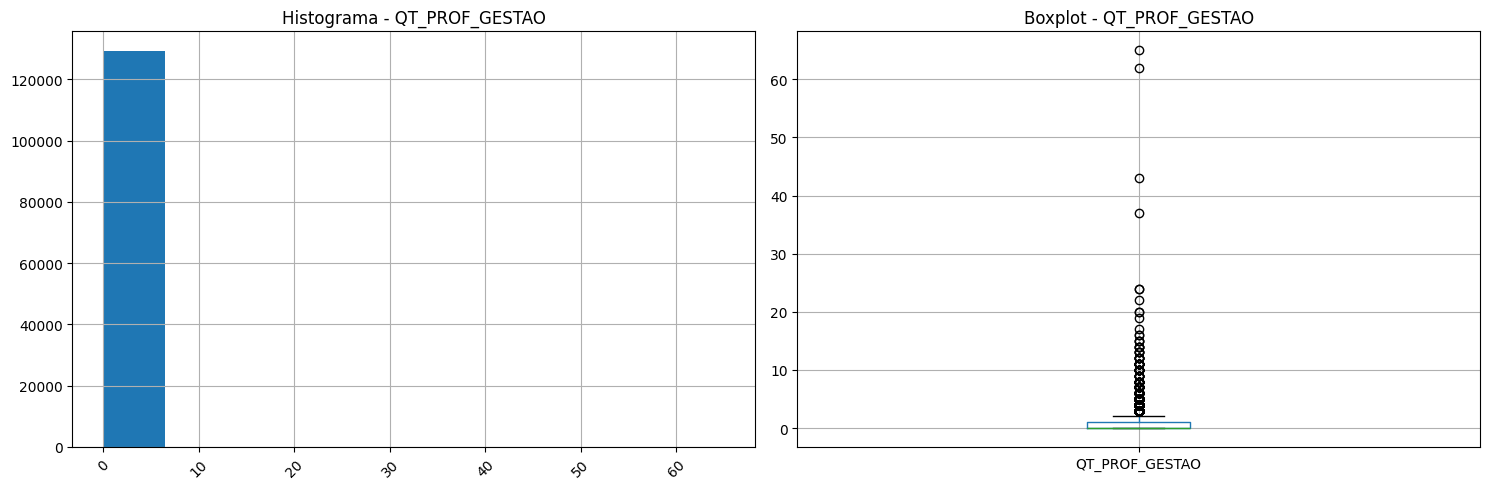

In [29]:
# Exibe gráficos de todas as colunas qt_prof_cols
for col in qt_prof_cols:
     exibe_graficos_coluna(df_censo_eda, col)

In [30]:
#Já que não surtiu efeito removendo 88888, vamos substituir pela mediana
#Criar dataframe sem os outliers
df_sem_outliers, stats_remocao = tratar_outliers_iqr(
    df_censo_eda,
    qt_prof_cols,
    estrategia='substituir',
    valor_substituicao='mediana',
    mostrar_stats=True
)

1. Total inicial: 129314

2. Colunas sendo analisadas:
['QT_PROF_ADMINISTRATIVOS', 'QT_PROF_SERVICOS_GERAIS', 'QT_PROF_BIBLIOTECARIO', 'QT_PROF_SAUDE', 'QT_PROF_ALIMENTACAO', 'QT_PROF_SEGURANCA', 'QT_PROF_GESTAO']

3. Análise de outliers por coluna:

Coluna: QT_PROF_ADMINISTRATIVOS
Q1: 0.00
Q3: 2.00
IQR: 2.00
Limite inferior: -3.00
Limite superior: 5.00
Número de outliers: 7289
Percentual de outliers: 5.64%

Coluna: QT_PROF_SERVICOS_GERAIS
Q1: 1.00
Q3: 5.00
IQR: 4.00
Limite inferior: -5.00
Limite superior: 11.00
Número de outliers: 5055
Percentual de outliers: 3.91%

Coluna: QT_PROF_BIBLIOTECARIO
Q1: 0.00
Q3: 0.00
IQR: 0.00
Limite inferior: 0.00
Limite superior: 0.00
Número de outliers: 32059
Percentual de outliers: 24.79%

Coluna: QT_PROF_SAUDE
Q1: 0.00
Q3: 0.00
IQR: 0.00
Limite inferior: 0.00
Limite superior: 0.00
Número de outliers: 3890
Percentual de outliers: 3.01%

Coluna: QT_PROF_ALIMENTACAO
Q1: 0.00
Q3: 2.00
IQR: 2.00
Limite inferior: -3.00
Limite superior: 5.00
Número de outli

In [31]:
# Aplica as remoções
df_censo_eda = df_sem_outliers

In [32]:
# Exibir o resultado
print("\nResumo dos Outliers por Coluna:")
print("--------------------------------")
print(analise_outliers(df_censo_eda))


Resumo dos Outliers por Coluna:
--------------------------------
Comparação com estatísticas descritivas:

Descrição do DataFrame:
       TX_APROV_FUND   TX_APROV_MED   TX_REPR_FUND    TX_REPR_MED  \
count  129314.000000  129314.000000  129314.000000  129314.000000   
mean       96.407475      91.513661       2.236415       3.471699   
std         7.266941       8.574447       5.562789       4.790225   
min         0.000000       0.000000       0.000000       0.000000   
25%        96.100000      87.800000       0.000000       0.200000   
50%        99.400000      94.100000       0.000000       1.800000   
75%       100.000000      97.900000       1.800000       4.700000   
max       100.000000     100.000000     100.000000     100.000000   

         TX_DIS_FUND     TX_DIS_MED     M_ATU_FUND      M_ATU_MED  \
count  129314.000000  129314.000000  129314.000000  129314.000000   
mean       14.209263      26.583007      18.244380       6.083333   
std        14.446314      16.299785    

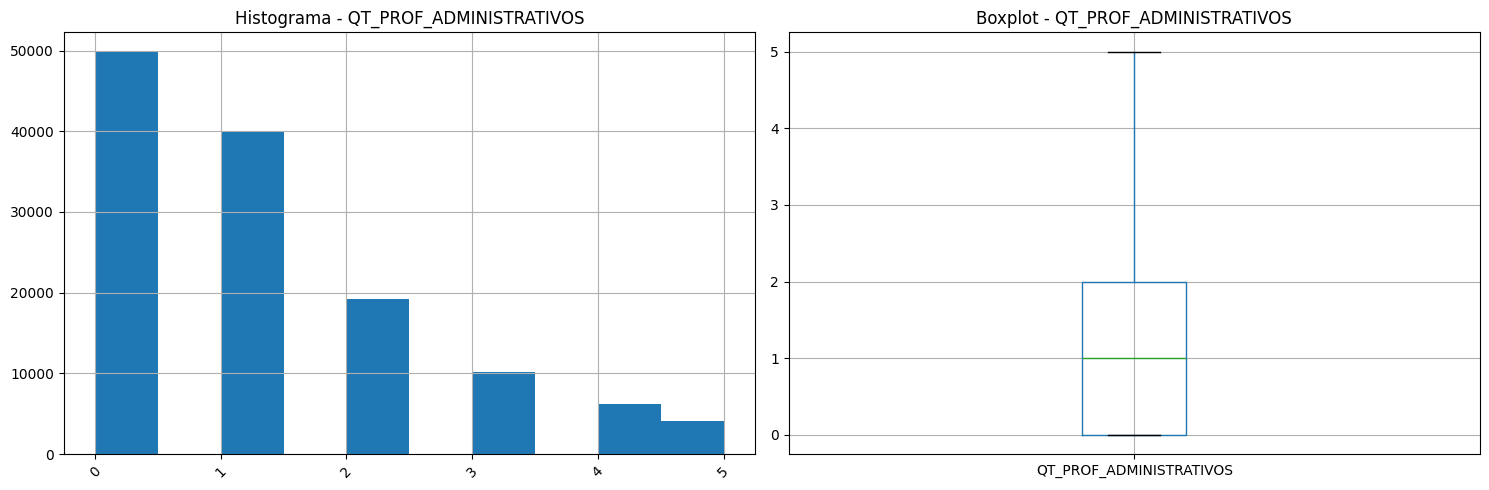

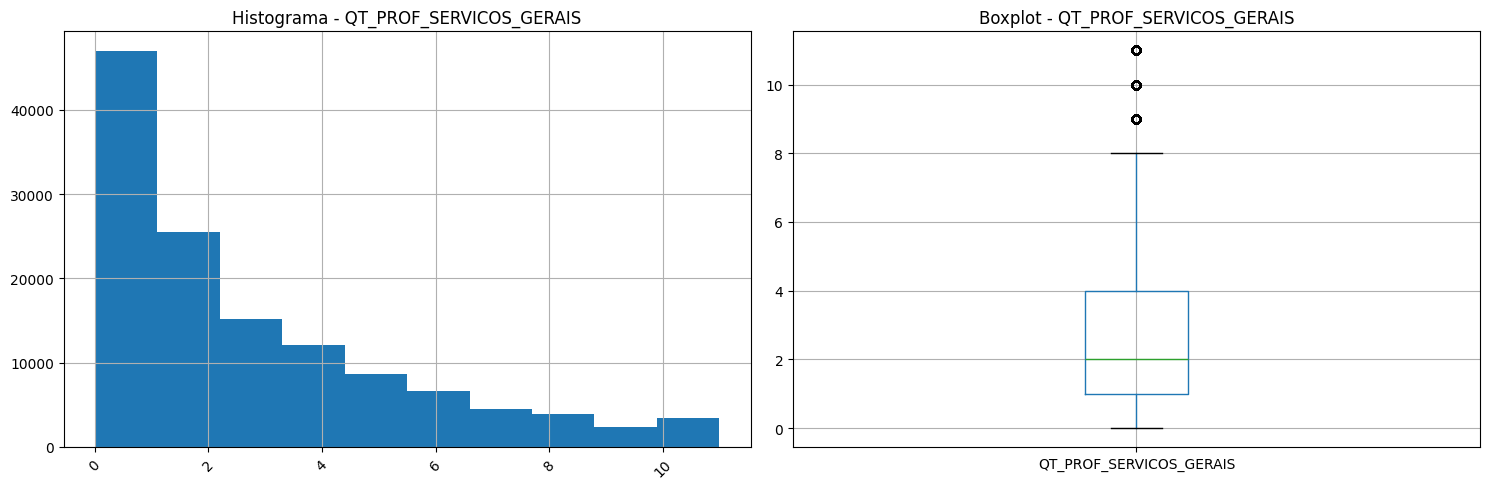

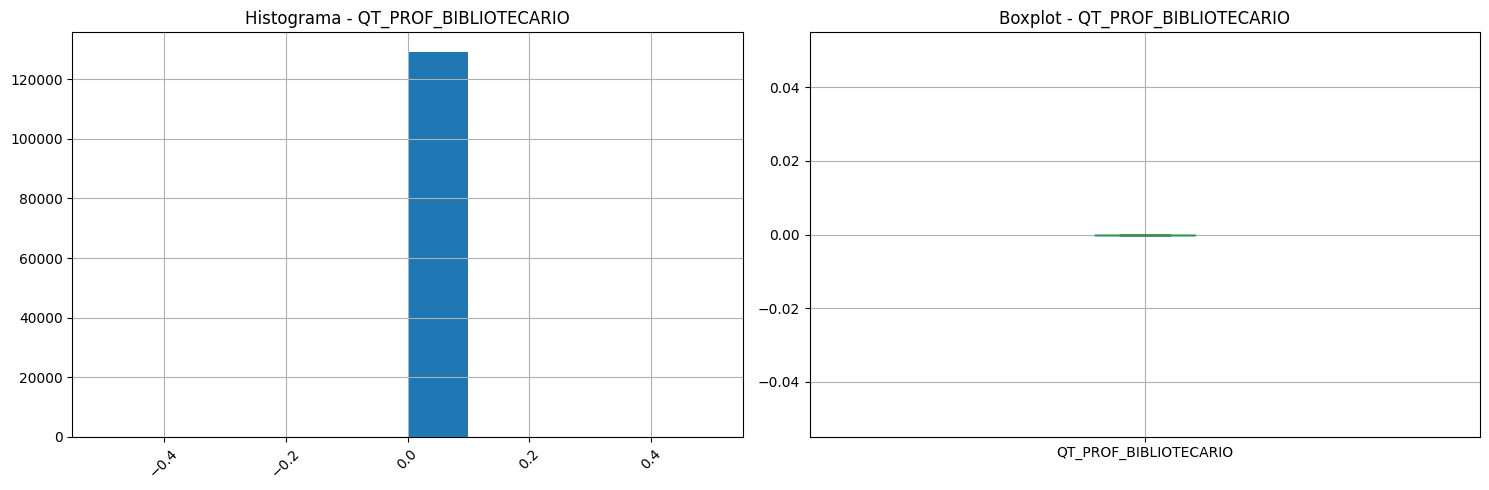

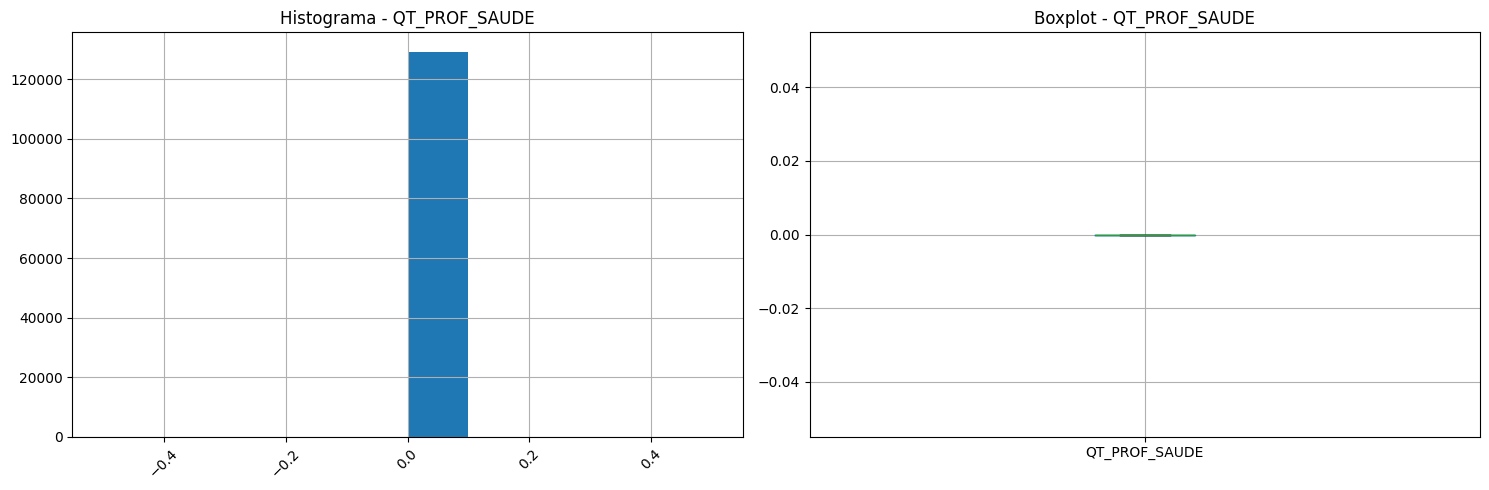

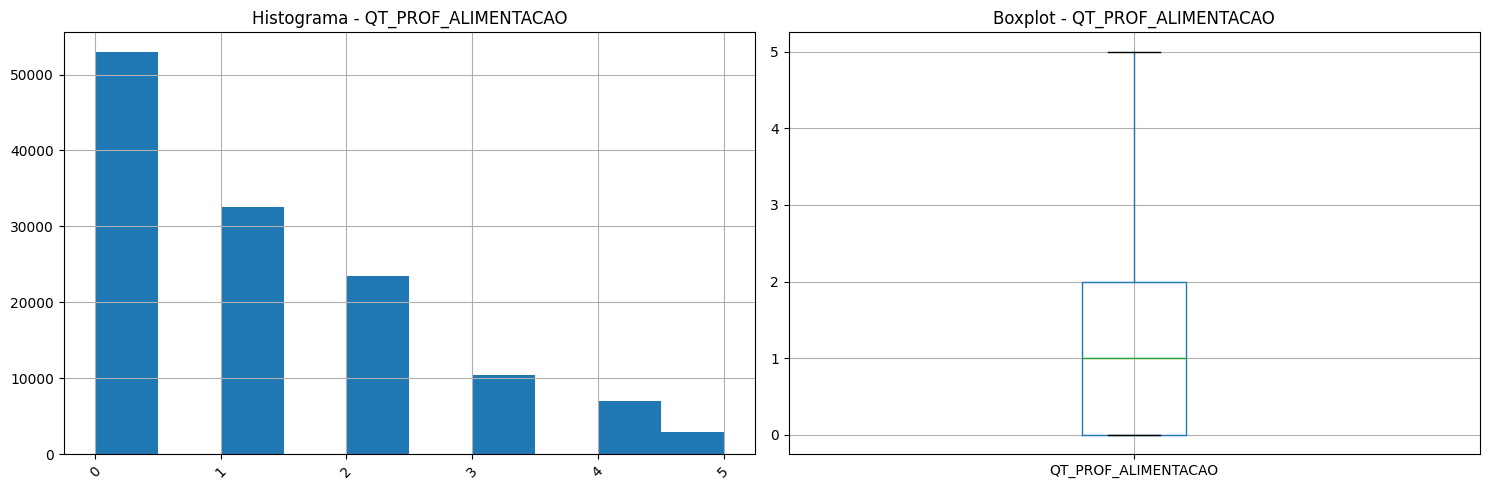

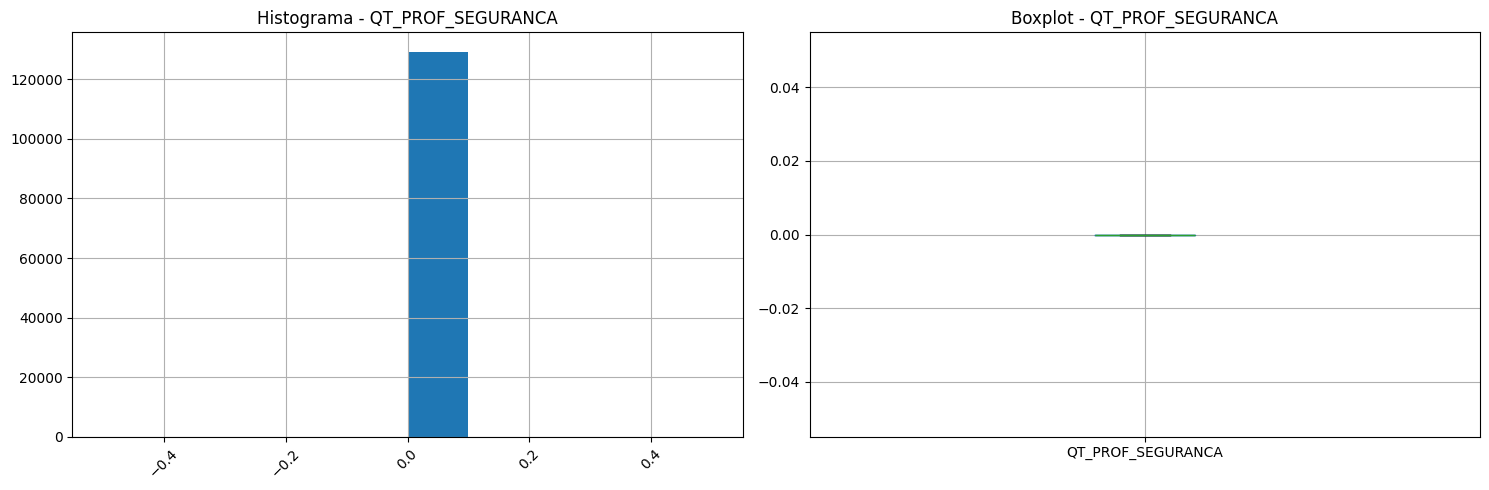

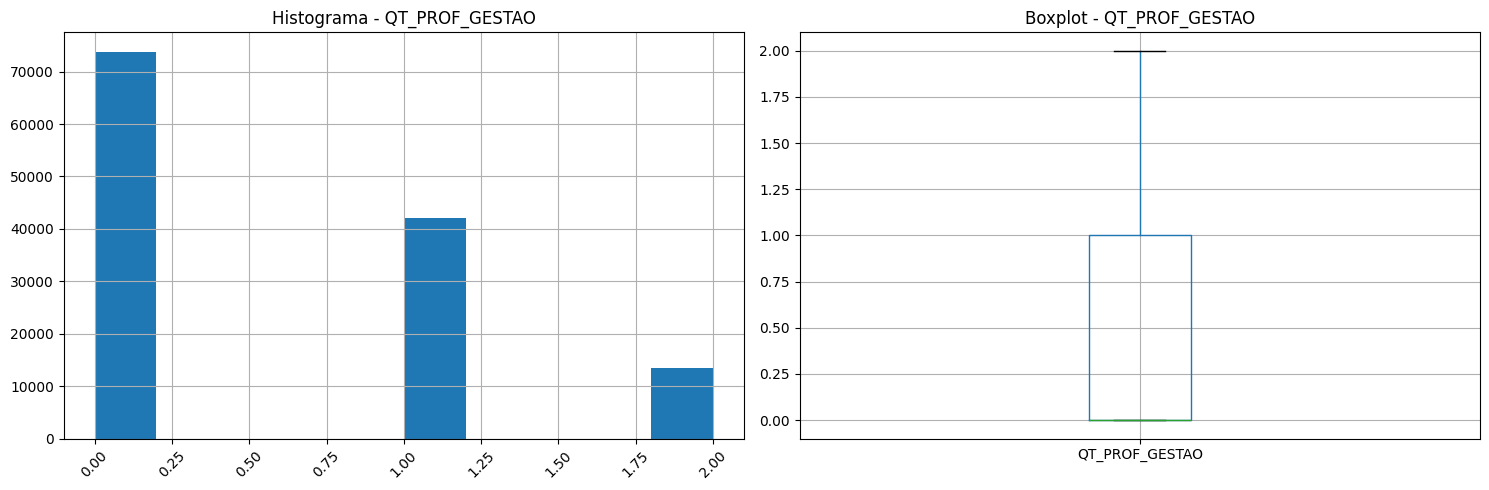

In [33]:
# Exibe gráficos de todas as colunas qt_prof_cols
for col in qt_prof_cols:
     exibe_graficos_coluna(df_censo_eda, col)

QT_SALAS

In [34]:
qt_salas_cols = [col for col in df_censo_eda.columns if col.startswith('QT_SALAS')]

# Criar dataframe sem os outliers
df_sem_outliers, stats_remocao = tratar_outliers_iqr(
    df_censo_eda,
    qt_salas_cols,
    estrategia='substituir',
    valor_substituicao='mediana',
    mostrar_stats=True
)

1. Total inicial: 129314

2. Colunas sendo analisadas:
['QT_SALAS_UTILIZADAS', 'QT_SALAS_UTILIZA_CLIMATIZADAS', 'QT_SALAS_UTILIZADAS_ACESSIVEIS']

3. Análise de outliers por coluna:

Coluna: QT_SALAS_UTILIZADAS
Q1: 4.00
Q3: 12.00
IQR: 8.00
Limite inferior: -8.00
Limite superior: 24.00
Número de outliers: 4110
Percentual de outliers: 3.18%

Coluna: QT_SALAS_UTILIZA_CLIMATIZADAS
Q1: 0.00
Q3: 4.00
IQR: 4.00
Limite inferior: -6.00
Limite superior: 10.00
Número de outliers: 13104
Percentual de outliers: 10.13%

Coluna: QT_SALAS_UTILIZADAS_ACESSIVEIS
Q1: 0.00
Q3: 2.00
IQR: 2.00
Limite inferior: -3.00
Limite superior: 5.00
Número de outliers: 21782
Percentual de outliers: 16.84%

4. Resultado final (Substituição):
Quantidade de registros: 129,314
Total de valores substituídos: 38,996
Percentual de valores substituídos: 10.05%

Método de substituição: mediana


In [35]:
# Exibir o resultado
print("\nResumo dos Outliers por Coluna:")
print("--------------------------------")
print(analise_outliers(df_sem_outliers))


Resumo dos Outliers por Coluna:
--------------------------------
Comparação com estatísticas descritivas:

Descrição do DataFrame:
       TX_APROV_FUND   TX_APROV_MED   TX_REPR_FUND    TX_REPR_MED  \
count  129314.000000  129314.000000  129314.000000  129314.000000   
mean       96.407475      91.513661       2.236415       3.471699   
std         7.266941       8.574447       5.562789       4.790225   
min         0.000000       0.000000       0.000000       0.000000   
25%        96.100000      87.800000       0.000000       0.200000   
50%        99.400000      94.100000       0.000000       1.800000   
75%       100.000000      97.900000       1.800000       4.700000   
max       100.000000     100.000000     100.000000     100.000000   

         TX_DIS_FUND     TX_DIS_MED     M_ATU_FUND      M_ATU_MED  \
count  129314.000000  129314.000000  129314.000000  129314.000000   
mean       14.209263      26.583007      18.244380       6.083333   
std        14.446314      16.299785    

In [36]:
# Considerando que a ação anterior gerou mais outlier, pois devido a substituição pela mediana pode ocorrer porque o IQR é recalculado após cada substituição, alterando os limites do que é considerado outlier. Portanto usar a estratégia de substituição pelos limites do IQR ('limite'),  pois é mais conservadora e evita distorcer a distribuição dos dados

df_sem_outliers, stats_remocao = tratar_outliers_iqr(
    df_censo_eda,
    qt_salas_cols,
    estrategia='substituir',
    valor_substituicao='limite',
    mostrar_stats=True
)

1. Total inicial: 129314

2. Colunas sendo analisadas:
['QT_SALAS_UTILIZADAS', 'QT_SALAS_UTILIZA_CLIMATIZADAS', 'QT_SALAS_UTILIZADAS_ACESSIVEIS']

3. Análise de outliers por coluna:

Coluna: QT_SALAS_UTILIZADAS
Q1: 4.00
Q3: 12.00
IQR: 8.00
Limite inferior: -8.00
Limite superior: 24.00
Número de outliers: 4110
Percentual de outliers: 3.18%

Coluna: QT_SALAS_UTILIZA_CLIMATIZADAS
Q1: 0.00
Q3: 4.00
IQR: 4.00
Limite inferior: -6.00
Limite superior: 10.00
Número de outliers: 13104
Percentual de outliers: 10.13%

Coluna: QT_SALAS_UTILIZADAS_ACESSIVEIS
Q1: 0.00
Q3: 2.00
IQR: 2.00
Limite inferior: -3.00
Limite superior: 5.00
Número de outliers: 21782
Percentual de outliers: 16.84%

4. Resultado final (Substituição):
Quantidade de registros: 129,314
Total de valores substituídos: 0
Percentual de valores substituídos: 0.00%

Método de substituição: limite


In [37]:
# Exibir o resultado
print("\nResumo dos Outliers por Coluna:")
print("--------------------------------")
print(analise_outliers(df_sem_outliers))


Resumo dos Outliers por Coluna:
--------------------------------
Comparação com estatísticas descritivas:

Descrição do DataFrame:
       TX_APROV_FUND   TX_APROV_MED   TX_REPR_FUND    TX_REPR_MED  \
count  129314.000000  129314.000000  129314.000000  129314.000000   
mean       96.407475      91.513661       2.236415       3.471699   
std         7.266941       8.574447       5.562789       4.790225   
min         0.000000       0.000000       0.000000       0.000000   
25%        96.100000      87.800000       0.000000       0.200000   
50%        99.400000      94.100000       0.000000       1.800000   
75%       100.000000      97.900000       1.800000       4.700000   
max       100.000000     100.000000     100.000000     100.000000   

         TX_DIS_FUND     TX_DIS_MED     M_ATU_FUND      M_ATU_MED  \
count  129314.000000  129314.000000  129314.000000  129314.000000   
mean       14.209263      26.583007      18.244380       6.083333   
std        14.446314      16.299785    

 'M_ATU_MED', 'QT_TUR_MED', 'QT_TUR_FUND', 'M_HAU_FUND', 'M_HAU_MED'

In [38]:
colunas_quantidades = ['QT_TUR_MED', 'QT_TUR_FUND']
df_sem_outliers, stats_remocao = tratar_outliers_iqr(
    df_censo_eda,
    colunas_quantidades,
    estrategia='substituir',
    valor_substituicao='mediana',
    mostrar_stats=True
)

1. Total inicial: 129314

2. Colunas sendo analisadas:
['QT_TUR_MED', 'QT_TUR_FUND']

3. Análise de outliers por coluna:

Coluna: QT_TUR_MED
Q1: 0.00
Q3: 0.00
IQR: 0.00
Limite inferior: 0.00
Limite superior: 0.00
Número de outliers: 28920
Percentual de outliers: 22.36%

Coluna: QT_TUR_FUND
Q1: 3.00
Q3: 13.00
IQR: 10.00
Limite inferior: -12.00
Limite superior: 28.00
Número de outliers: 3611
Percentual de outliers: 2.79%

4. Resultado final (Substituição):
Quantidade de registros: 129,314
Total de valores substituídos: 32,531
Percentual de valores substituídos: 12.58%

Método de substituição: mediana


In [39]:
# Exibir o resultado
print("\nResumo dos Outliers por Coluna:")
print("--------------------------------")
print(analise_outliers(df_sem_outliers[colunas_quantidades]))


Resumo dos Outliers por Coluna:
--------------------------------
Comparação com estatísticas descritivas:

Descrição do DataFrame:
       QT_TUR_MED    QT_TUR_FUND
count    129314.0  129314.000000
mean          0.0       8.137990
std           0.0       6.547393
min           0.0       0.000000
25%           0.0       3.000000
50%           0.0       7.000000
75%           0.0      12.000000
max           0.0      28.000000
        Coluna  Total_Outliers  Percentual_Outliers  Limite_Inferior  \
1  QT_TUR_FUND            2174                 1.68            -10.5   
0   QT_TUR_MED               0                 0.00              0.0   

   Limite_Superior  Max_Real  
1             25.5        28  
0              0.0         0  


In [40]:
# Aplica os tratamentos
df_censo_eda = df_sem_outliers

In [41]:
colunas_media = ['M_ATU_MED', 'M_HAU_FUND', 'M_HAU_MED']

df_sem_outliers, stats_remocao = tratar_outliers_iqr(
    df_censo_eda,
    colunas_media,
    estrategia='substituir',
    valor_substituicao='limite',
    mostrar_stats=True
)

1. Total inicial: 129314

2. Colunas sendo analisadas:
['M_ATU_MED', 'M_HAU_FUND', 'M_HAU_MED']

3. Análise de outliers por coluna:

Coluna: M_ATU_MED
Q1: 0.00
Q3: 0.00
IQR: 0.00
Limite inferior: 0.00
Limite superior: 0.00
Número de outliers: 28920
Percentual de outliers: 22.36%

Coluna: M_HAU_FUND
Q1: 4.00
Q3: 4.60
IQR: 0.60
Limite inferior: 3.10
Limite superior: 5.50
Número de outliers: 11381
Percentual de outliers: 8.80%

Coluna: M_HAU_MED
Q1: 4.50
Q3: 5.70
IQR: 1.20
Limite inferior: 2.70
Limite superior: 7.50
Número de outliers: 6664
Percentual de outliers: 5.15%

4. Resultado final (Substituição):
Quantidade de registros: 129,314
Total de valores substituídos: 0
Percentual de valores substituídos: 0.00%

Método de substituição: limite


In [42]:
# Exibir o resultado
print("\nResumo dos Outliers por Coluna:")
print("--------------------------------")
print(analise_outliers(df_sem_outliers[colunas_media]))


Resumo dos Outliers por Coluna:
--------------------------------
Comparação com estatísticas descritivas:

Descrição do DataFrame:
       M_ATU_MED     M_HAU_FUND      M_HAU_MED
count   129314.0  129314.000000  129314.000000
mean         0.0       4.458260       5.261546
std          0.0       0.469229       0.945136
min          0.0       3.100000       2.700000
25%          0.0       4.000000       4.500000
50%          0.0       4.300000       5.100000
75%          0.0       4.600000       5.700000
max          0.0       5.500000       7.500000
       Coluna  Total_Outliers  Percentual_Outliers  Limite_Inferior  \
0   M_ATU_MED               0                  0.0              0.0   
1  M_HAU_FUND               0                  0.0              3.1   
2   M_HAU_MED               0                  0.0              2.7   

   Limite_Superior  Max_Real  
0              0.0       0.0  
1              5.5       5.5  
2              7.5       7.5  


In [43]:
# Aplica os tratamentos
df_censo_eda = df_sem_outliers

TAXAS

In [44]:
# TX_EV_TOT é um dado categórico

colunas_taxas = ['TX_REPR_FUND', 'TX_APROV_FUND', 'TX_DSU_FUND', 'TX_DIS_FUND', 'TX_REPR_MED', 'TX_APROV_MED', 'TX_DSU_MED', 'TX_DIS_MED']

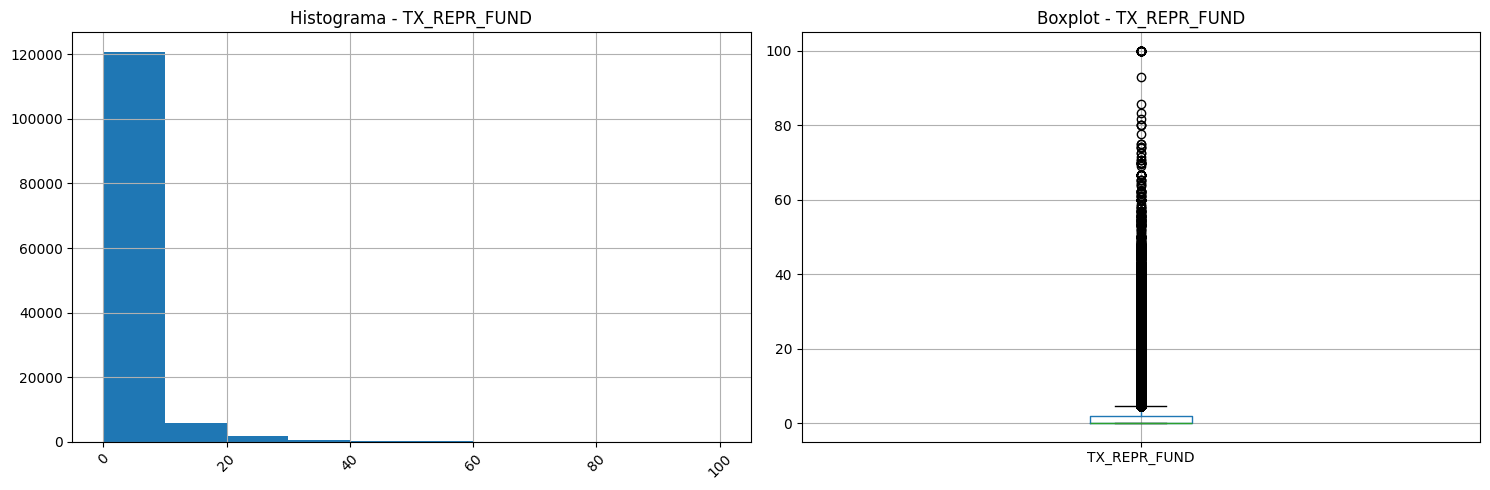

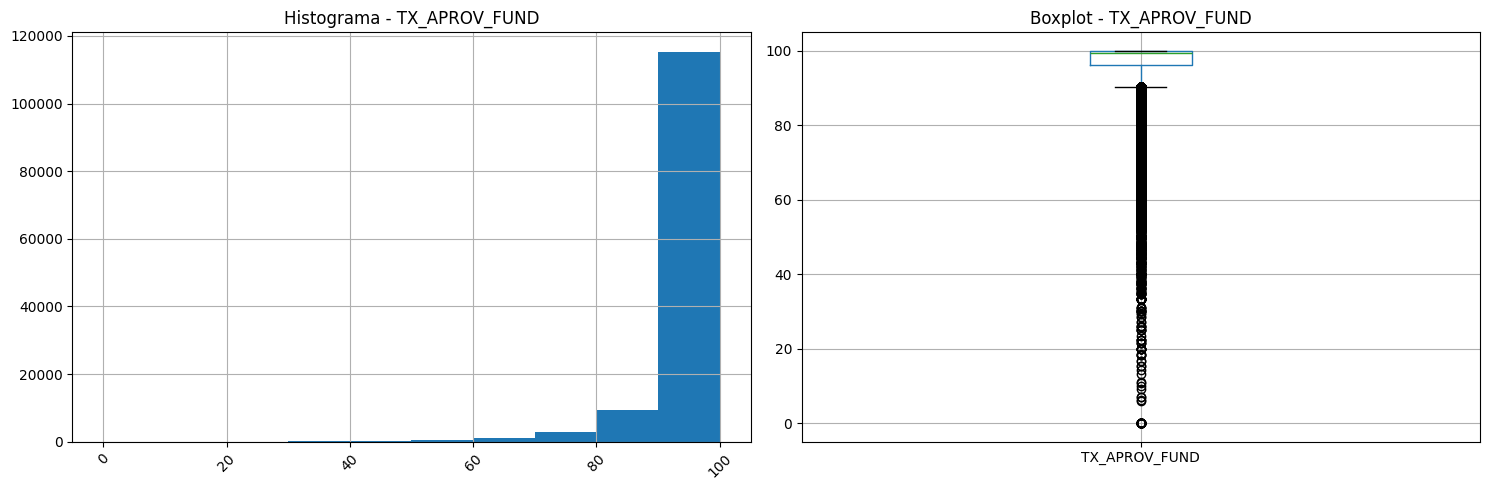

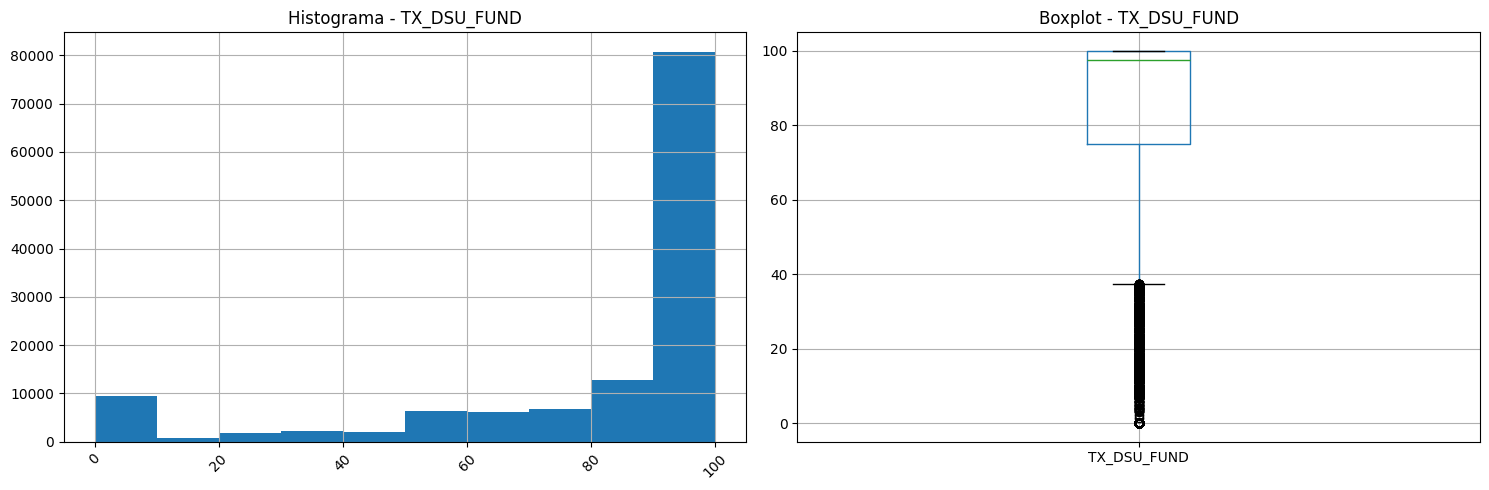

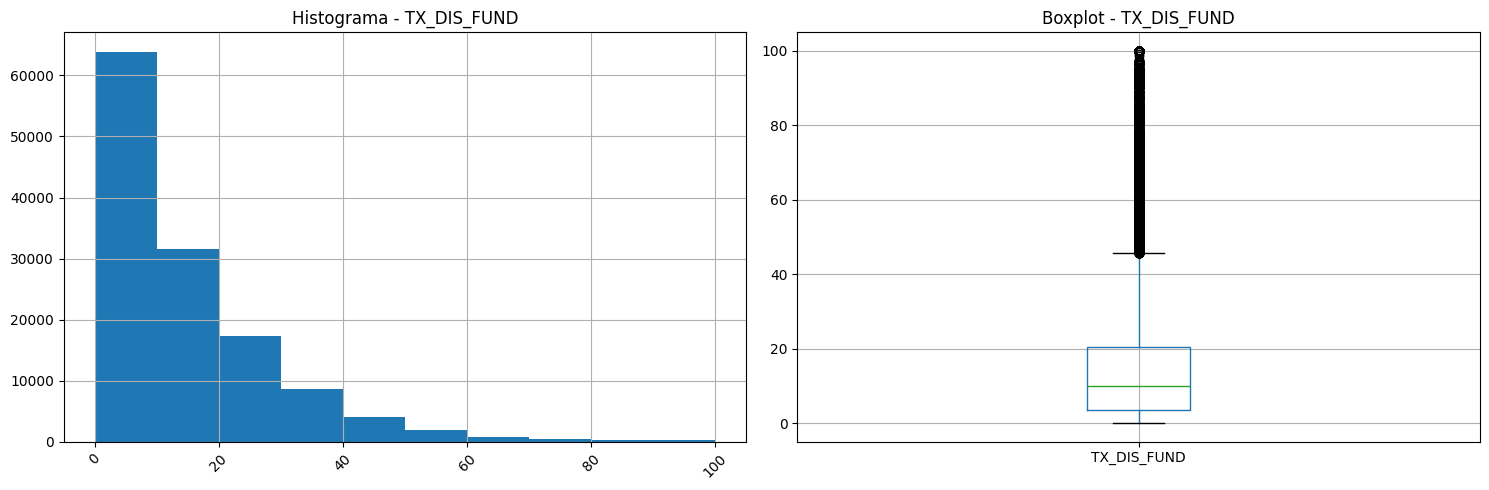

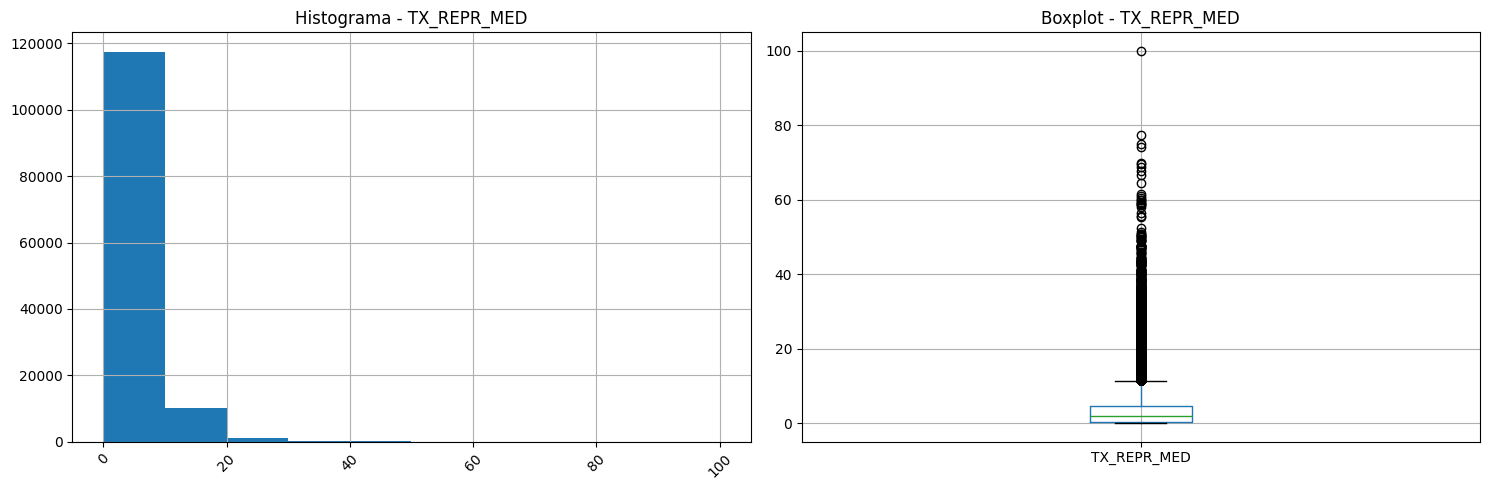

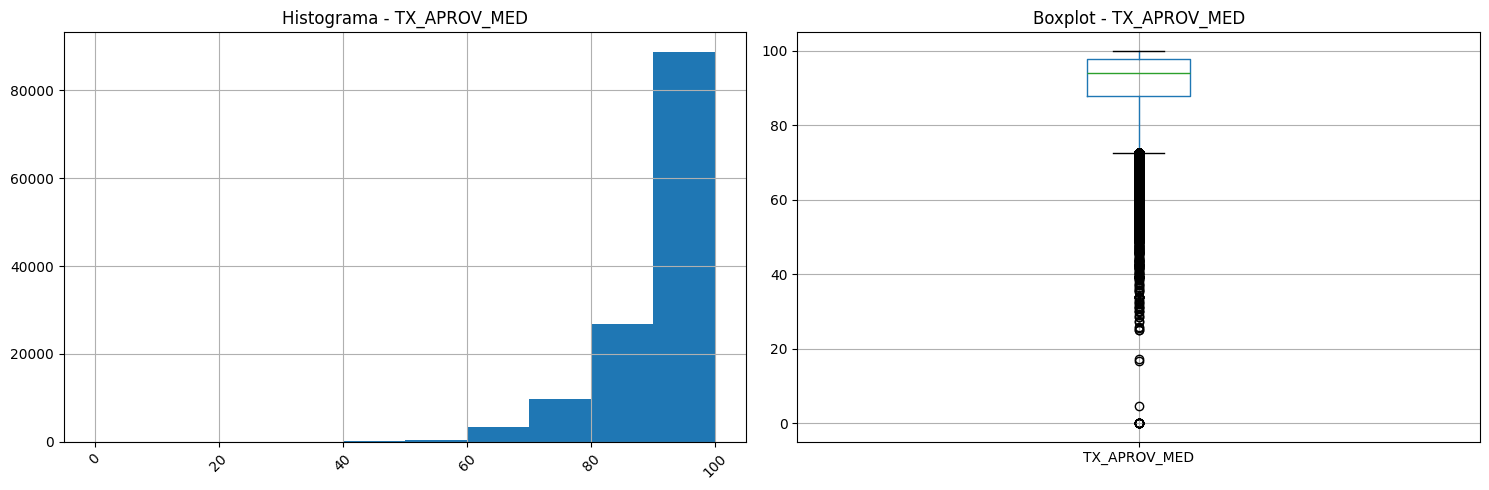

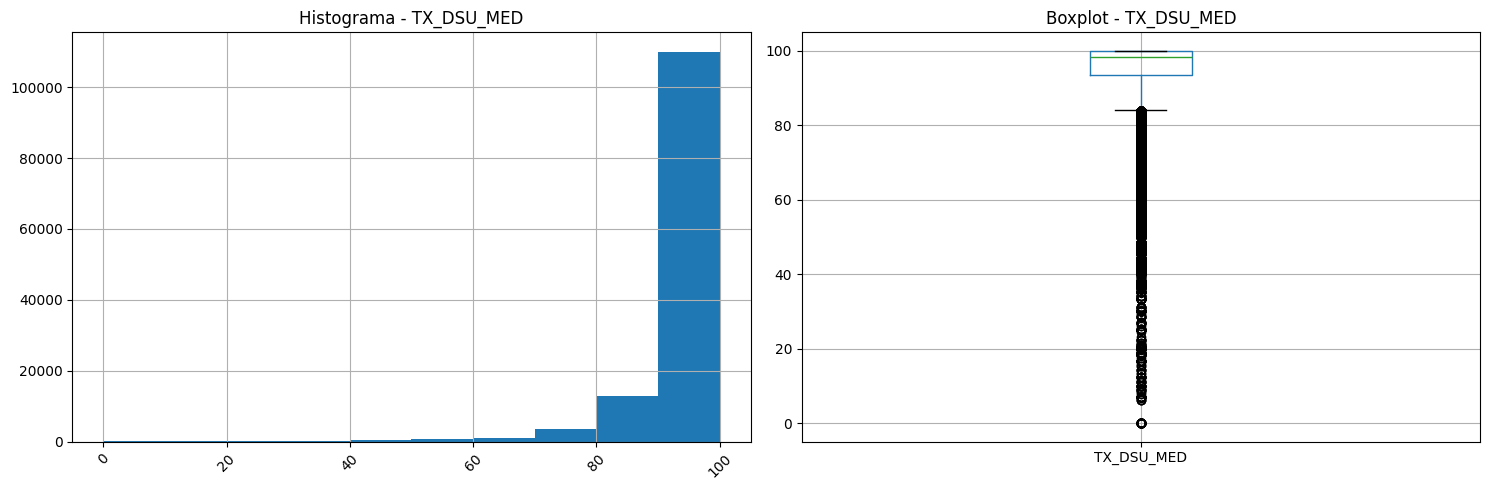

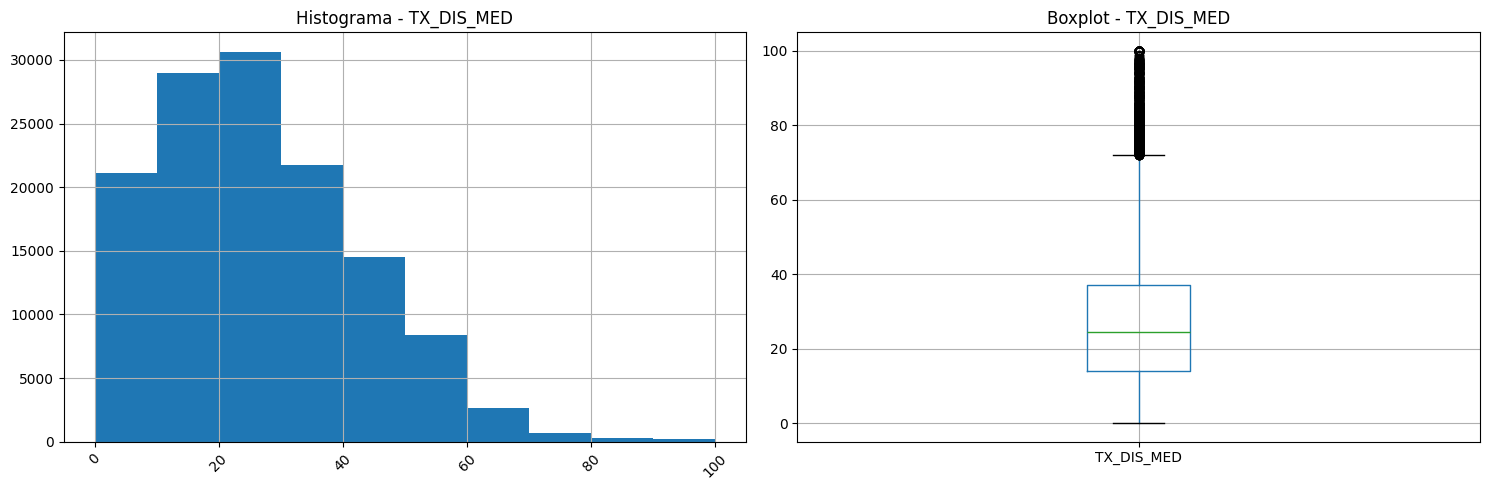

In [45]:
for col in colunas_taxas:
    exibe_graficos_coluna(df_censo_eda, col)

In [46]:
df_sem_outliers, stats_remocao = tratar_outliers_iqr(
    df_censo_eda,
    colunas_taxas,
    estrategia='substituir',
    valor_substituicao='limite',
    mostrar_stats=True
)

1. Total inicial: 129314

2. Colunas sendo analisadas:
['TX_REPR_FUND', 'TX_APROV_FUND', 'TX_DSU_FUND', 'TX_DIS_FUND', 'TX_REPR_MED', 'TX_APROV_MED', 'TX_DSU_MED', 'TX_DIS_MED']

3. Análise de outliers por coluna:

Coluna: TX_REPR_FUND
Q1: 0.00
Q3: 1.80
IQR: 1.80
Limite inferior: -2.70
Limite superior: 4.50
Número de outliers: 18998
Percentual de outliers: 14.69%

Coluna: TX_APROV_FUND
Q1: 96.10
Q3: 100.00
IQR: 3.90
Limite inferior: 90.25
Limite superior: 105.85
Número de outliers: 14696
Percentual de outliers: 11.36%

Coluna: TX_DSU_FUND
Q1: 75.00
Q3: 100.00
IQR: 25.00
Limite inferior: 37.50
Limite superior: 137.50
Número de outliers: 14173
Percentual de outliers: 10.96%

Coluna: TX_DIS_FUND
Q1: 3.50
Q3: 20.40
IQR: 16.90
Limite inferior: -21.85
Limite superior: 45.75
Número de outliers: 4925
Percentual de outliers: 3.81%

Coluna: TX_REPR_MED
Q1: 0.20
Q3: 4.70
IQR: 4.50
Limite inferior: -6.55
Limite superior: 11.45
Número de outliers: 9113
Percentual de outliers: 7.05%

Coluna: TX_APRO

In [47]:
# Exibir o resultado
print("\nResumo dos Outliers por Coluna:")
print("--------------------------------")
print(analise_outliers(df_sem_outliers[colunas_taxas]))


Resumo dos Outliers por Coluna:
--------------------------------
Comparação com estatísticas descritivas:

Descrição do DataFrame:
        TX_REPR_FUND  TX_APROV_FUND    TX_DSU_FUND    TX_DIS_FUND  \
count  129314.000000  129314.000000  129314.000000  129314.000000   
mean        1.104051      97.531359      84.422169      13.657831   
std         1.699531       3.412148      21.981321      12.568160   
min         0.000000      90.250000      37.500000       0.000000   
25%         0.000000      96.100000      75.000000       3.500000   
50%         0.000000      99.400000      97.600000      10.000000   
75%         1.800000     100.000000     100.000000      20.400000   
max         4.500000     100.000000     100.000000      45.750000   

         TX_REPR_MED   TX_APROV_MED     TX_DSU_MED     TX_DIS_MED  
count  129314.000000  129314.000000  129314.000000  129314.000000  
mean        3.102069      91.799679      96.016965      26.499405  
std         3.533285       7.660331       

In [48]:
df_censo_eda = df_sem_outliers

In [49]:
# Exibir o resultado
print("\nResumo dos Outliers por Coluna:")
print("--------------------------------")
print(analise_outliers(df_censo_eda))


Resumo dos Outliers por Coluna:
--------------------------------
Comparação com estatísticas descritivas:

Descrição do DataFrame:
       TX_APROV_FUND   TX_APROV_MED   TX_REPR_FUND    TX_REPR_MED  \
count  129314.000000  129314.000000  129314.000000  129314.000000   
mean       97.531359      91.799679       1.104051       3.102069   
std         3.412148       7.660331       1.699531       3.533285   
min        90.250000      72.650000       0.000000       0.000000   
25%        96.100000      87.800000       0.000000       0.200000   
50%        99.400000      94.100000       0.000000       1.800000   
75%       100.000000      97.900000       1.800000       4.700000   
max       100.000000     100.000000       4.500000      11.450000   

         TX_DIS_FUND     TX_DIS_MED     M_ATU_FUND  M_ATU_MED    TX_DSU_FUND  \
count  129314.000000  129314.000000  129314.000000   129314.0  129314.000000   
mean       13.657831      26.499405      18.244380        0.0      84.422169   
std   

CORRELAÇÃO

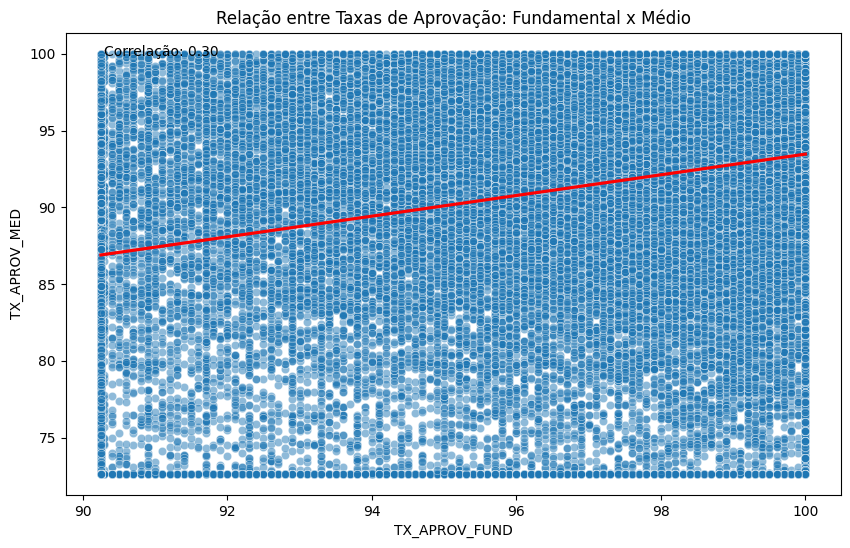


Estatísticas Descritivas:
       TX_APROV_FUND   TX_APROV_MED
count  129314.000000  129314.000000
mean       97.531359      91.799679
std         3.412148       7.660331
min        90.250000      72.650000
25%        96.100000      87.800000
50%        99.400000      94.100000
75%       100.000000      97.900000
max       100.000000     100.000000


In [50]:
# Analisar relação entre aprovações
correlacao_aprovacoes = analisar_relacao_aprovacoes(df_censo_eda)

In [51]:
#Optou-se por separar a base em Fundamental e Médio, pois as variavéis que influenciam o Fundamental podem influenciar o Médio, e vice-versa. Desse modo, podem enviesar a análise e resultados encontrados.

df_censo_fund = df_censo_eda.drop(columns=['TX_APROV_MED', 'QT_TUR_MED', 'M_HAU_MED', 'TX_DSU_MED', 'M_ATU_MED','TX_DIS_MED','TX_REPR_MED'], axis=1)
df_censo_med = df_censo_eda.drop(columns=['TX_APROV_FUND', 'QT_TUR_FUND', 'M_HAU_FUND', 'TX_DSU_FUND', 'M_ATU_FUND','TX_DIS_FUND','TX_REPR_FUND'], axis=1)

Correlação Ensino Fundamental


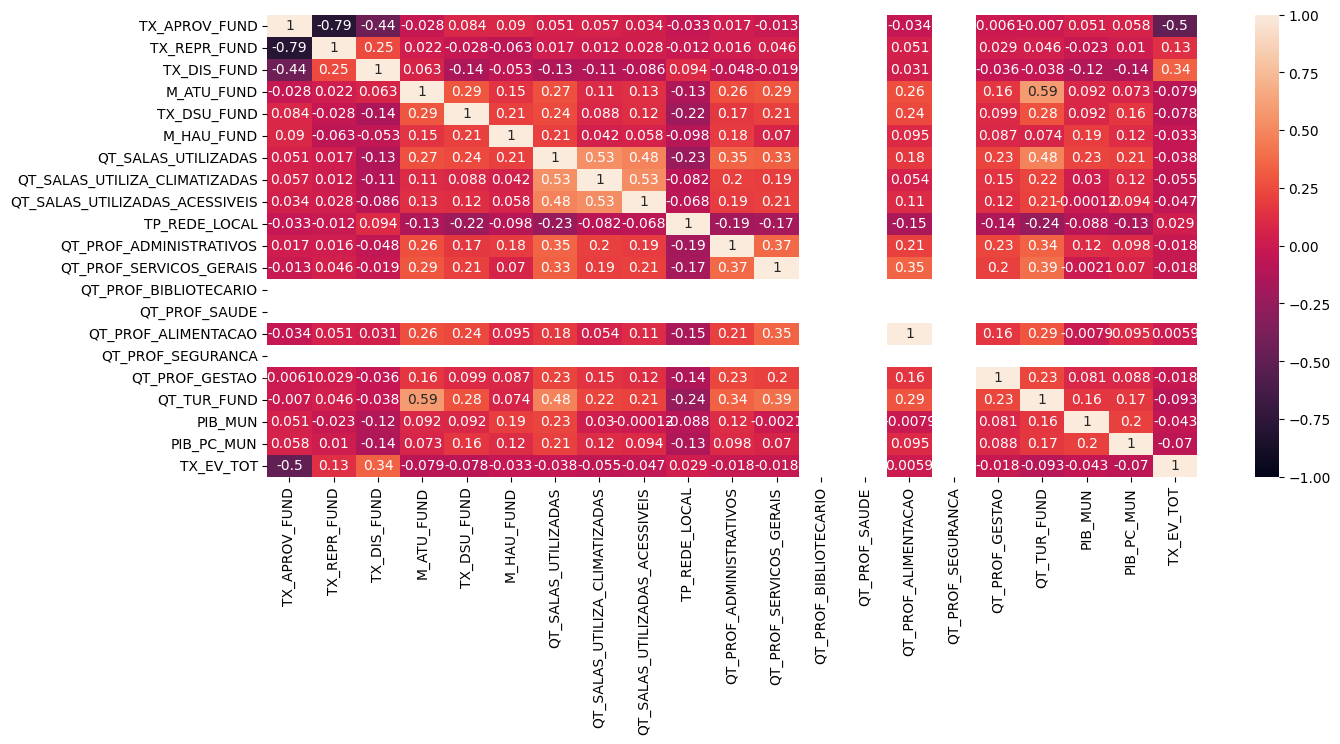

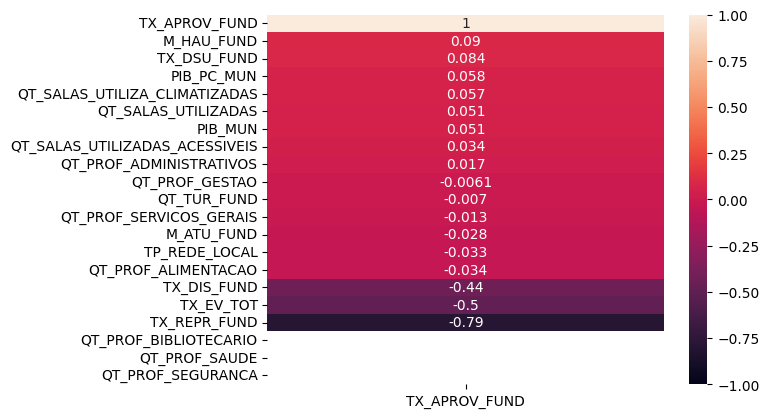

In [52]:
# Mapa de calor com correlação
plt.figure(figsize=(15, 6))
df_num = df_censo_fund.select_dtypes(include=['float64', 'int64'])
sns.heatmap(df_num.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

sns.heatmap(df_num.corr()[['TX_APROV_FUND']].sort_values(by='TX_APROV_FUND', ascending=False), vmin=-1, vmax=1, annot=True)
plt.show()

Correlação Ensino Médio

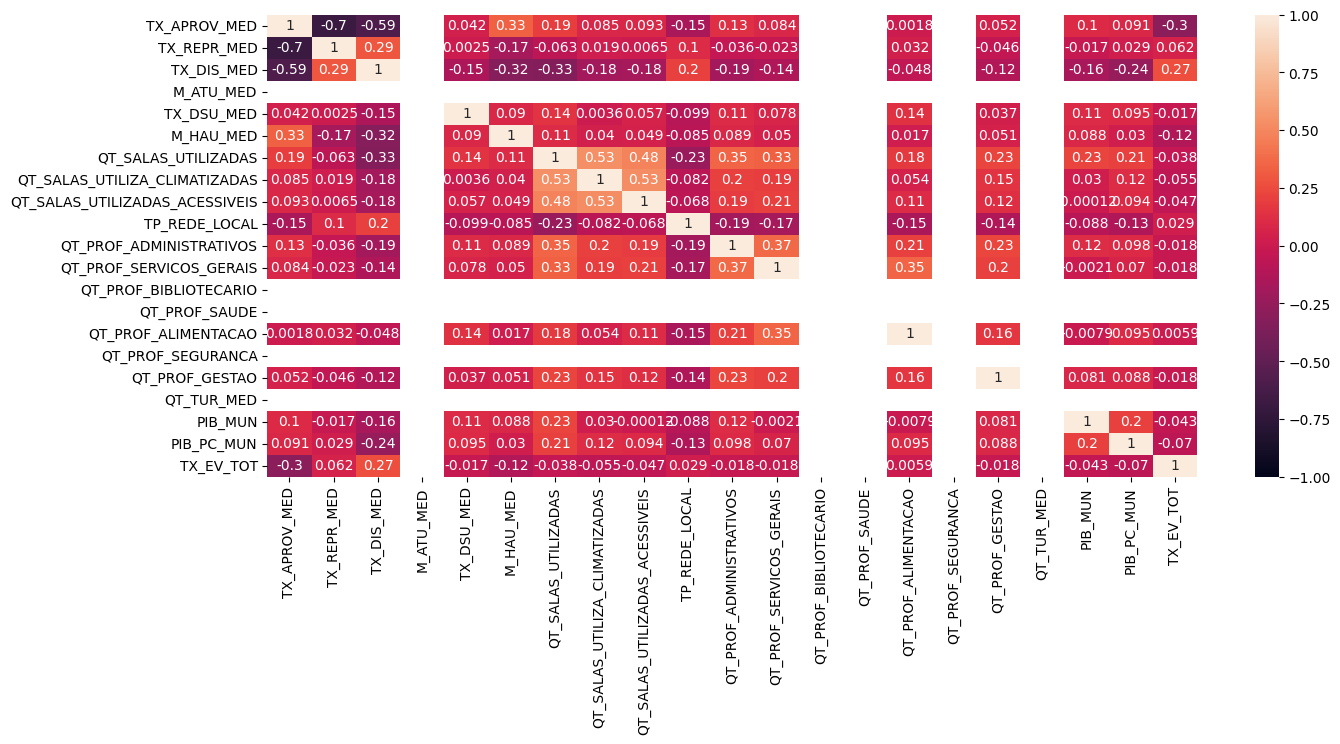

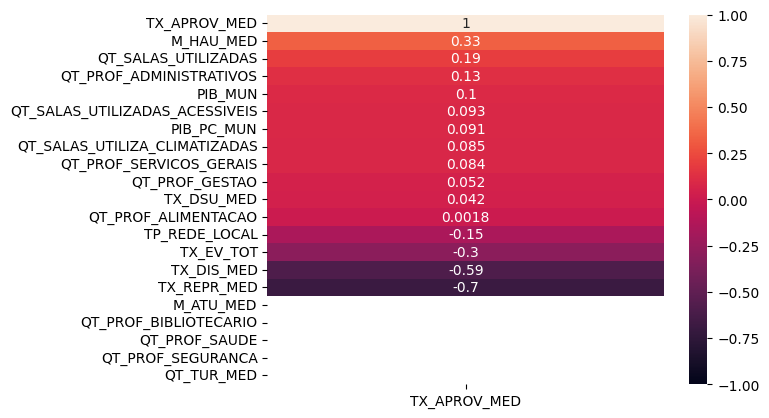

In [53]:
# Mapa de calor com correlação
plt.figure(figsize=(15, 6))
df_num = df_censo_med.select_dtypes(include=['float64', 'int64'])
sns.heatmap(df_num.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

sns.heatmap(df_num.corr()[['TX_APROV_MED']].sort_values(by='TX_APROV_MED', ascending=False), vmin=-1, vmax=1, annot=True)
plt.show()


Variáveis importantes para Taxa de Aprovação - Fundamental:


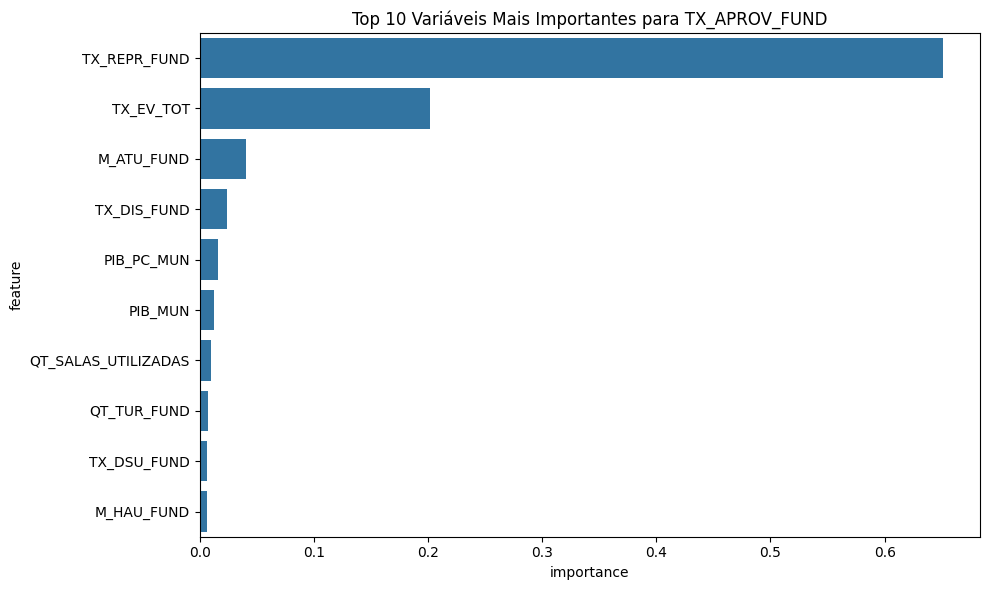


Variáveis importantes para Taxa de Aprovação - Médio:


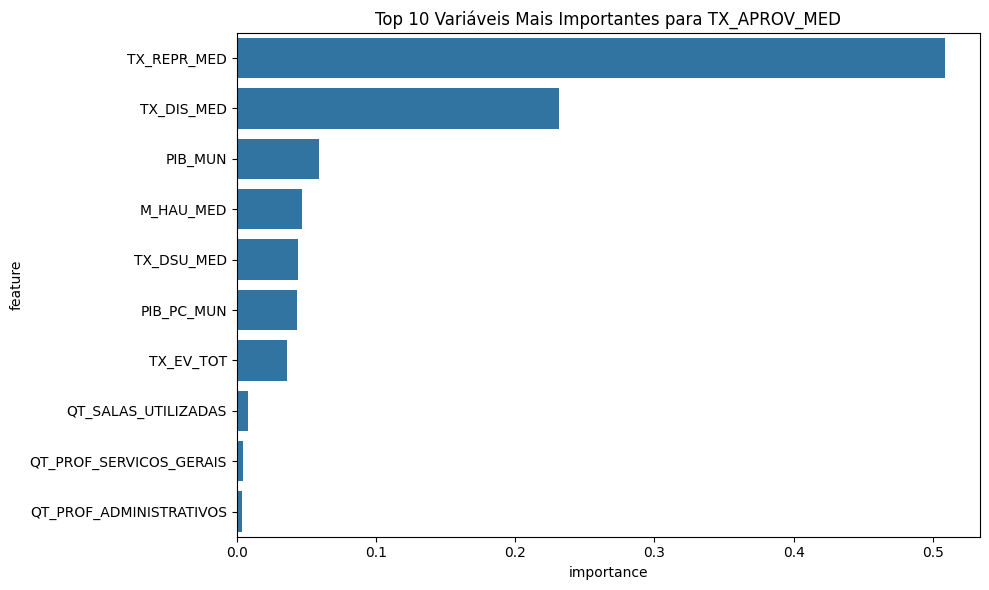

In [54]:
# Analisar variáveis importantes para cada taxa de aprovação com Random Forest
print("\nVariáveis importantes para Taxa de Aprovação - Fundamental:")
imp_fund = identificar_variaveis_importantes(df_censo_fund, 'TX_APROV_FUND')

print("\nVariáveis importantes para Taxa de Aprovação - Médio:")
imp_med = identificar_variaveis_importantes(df_censo_med, 'TX_APROV_MED')

## MODELO PREDITIVO

Modelo de forest por motivos de: não sei

Serão criados dois modelos: Um para o fundamental e outro para o médio -> Explicar o motivo

Funções

In [55]:
from sklearn.model_selection import cross_val_score

# Adicionar validação cruzada
def avaliar_com_cv(X, y, model, cv=5):
    """
    Avalia o modelo usando validação cruzada
    """
    scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    print(f"\nResultados da Validação Cruzada ({cv} folds):")
    print(f"R² médio: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    return scores

In [56]:
def preparar_e_dividir_dados(df, target_col, test_size=0.2, random_state=42):
    """
    Prepara os dados e divide em conjuntos de treino e teste

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame com os dados
    target_col : str
        Nome da coluna alvo (TX_APROV_FUND ou TX_APROV_MED)
    test_size : float
        Proporção dos dados para teste (default: 0.2 = 20%)
    random_state : int
        Semente aleatória para reprodutibilidade
    """
    from sklearn.model_selection import train_test_split

    # Separar features (X) e target (y)
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state
    )

    # Mostrar as dimensões dos conjuntos
    print("Dimensões dos conjuntos:")
    print(f"X_train: {X_train.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")

    return X_train, X_test, y_train, y_test

In [57]:
def analise_shap(model, X_train, feature_names=None):
    """
    Realiza análise de explicabilidade usando SHAP
    
    Parâmetros:
    model: Pipeline do sklearn com preprocessador e modelo
    X_train: DataFrame com dados de treino
    feature_names: Lista com nomes das features (opcional)
    
    Retorna:
    explainer: Objeto SHAP explainer
    """
    import shap
    
    # Pegar o modelo Random Forest do pipeline
    rf_model = model.named_steps['regressor']
    
    # Preparar os dados com o preprocessador
    X_train_processed = model.named_steps['preprocessor'].transform(X_train)
    
    # Se feature_names não foi fornecido, criar a partir do preprocessador
    if feature_names is None:
        feature_names = []
        for name, transformer, features in model.named_steps['preprocessor'].transformers_:
            if name == 'num':
                feature_names.extend(features)
            elif name == 'cat':
                for feature in features:
                    # Pegar categorias do OneHotEncoder
                    categories = transformer.get_feature_names_out([feature])
                    feature_names.extend(categories)
    
    # Criar o explainer SHAP
    explainer = shap.TreeExplainer(rf_model)
    
    # Calcular valores SHAP
    shap_values = explainer.shap_values(X_train_processed)
    
    # Plotar gráficos SHAP
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_train_processed, feature_names=feature_names, show=False)
    plt.title("SHAP Summary Plot")
    plt.tight_layout()
    plt.show()
    
    # Plot de dependência para as features mais importantes
    plt.figure(figsize=(15, 5))
    for i in range(min(3, len(feature_names))):  # Top 3 features
        plt.subplot(1, 3, i+1)
        shap.dependence_plot(i, shap_values, X_train_processed, feature_names=feature_names, show=False)
        plt.title(f"SHAP Dependence Plot - {feature_names[i]}")
    plt.tight_layout()
    plt.show()
    
    return explainer


In [58]:
def treinar_e_avaliar_modelo(X_train, X_test, y_train, y_test, target_col):
    """
    Treina o modelo e avalia seu desempenho
    """
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.ensemble import RandomForestRegressor
    import numpy as np

    # Definir tipos de features
    numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

    # Criar pipeline com preprocessamento e modelo
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ])

    # Criar e treinar o modelo
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Fazer previsões
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calcular métricas
    metrics = {
        'R² (Treino)': r2_score(y_train, y_pred_train),
        'R² (Teste)': r2_score(y_test, y_pred_test),
        'MAE (Treino)': mean_absolute_error(y_train, y_pred_train),
        'MAE (Teste)': mean_absolute_error(y_test, y_pred_test),
        'RMSE (Treino)': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'RMSE (Teste)': np.sqrt(mean_squared_error(y_test, y_pred_test))
    }

    # Mostrar resultados
    print(f"\nResultados para {target_col}:")
    print("-----------------------------")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Plotar resultados
    plt.figure(figsize=(12, 5))

    # Gráfico de dispersão - Treino
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_pred_train, alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    plt.xlabel('Valores Reais')
    plt.ylabel('Previsões')
    plt.title('Conjunto de Treino')

    # Gráfico de dispersão - Teste
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Valores Reais')
    plt.ylabel('Previsões')
    plt.title('Conjunto de Teste')

    plt.tight_layout()
    plt.show()
    
    # Realizar análise SHAP
    print("\nGerando análises SHAP...")
    explainer = analise_shap(model, X_train)

    return model, metrics, explainer

Criação do modelo


Análise para TX_APROV_FUND
Dimensões dos conjuntos:
X_train: (103451, 43)
X_test: (25863, 43)
y_train: (103451,)
y_test: (25863,)

Resultados para TX_APROV_FUND:
-----------------------------
R² (Treino): 0.9871
R² (Teste): 0.9078
MAE (Treino): 0.2345
MAE (Teste): 0.6322
RMSE (Treino): 0.3877
RMSE (Teste): 1.0338


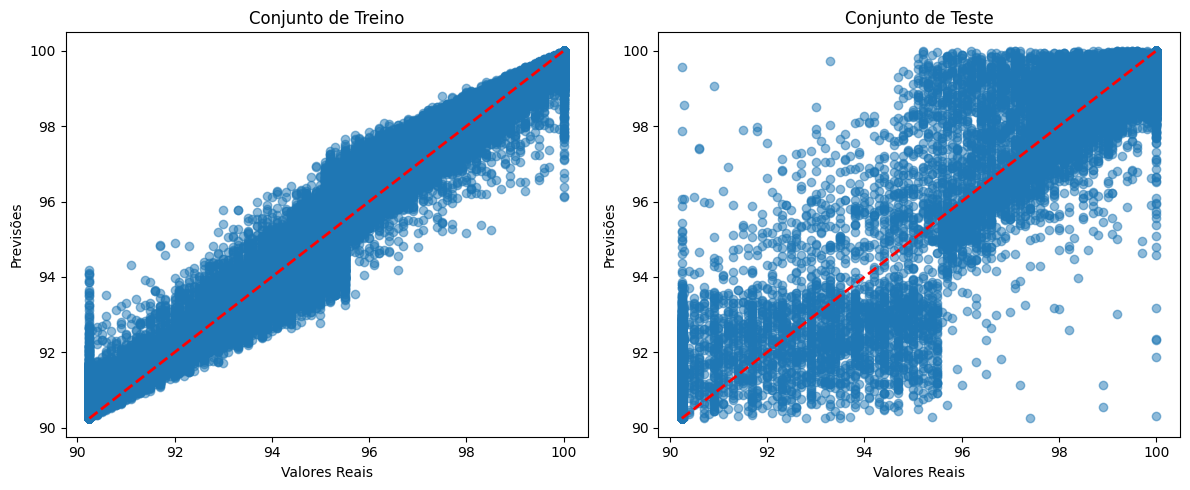


Gerando análises SHAP...


c:\Users\ilha\.virtualenvs\trabalho-analise-KG_idnSa\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# Aplicar para ambas as taxas de aprovação
for target in ['TX_APROV_FUND', 'TX_APROV_MED']:
    print(f"\nAnálise para {target}")
    print("="*50)

    # Preparar e dividir os dados
    X_train, X_test, y_train, y_test = preparar_e_dividir_dados(
        df_censo_eda,
        target_col=target
    )

    # Treinar e avaliar o modelo
    model, metrics = treinar_e_avaliar_modelo(
        X_train, X_test, y_train, y_test,
        target_col=target
    )

    # Adicionar validação cruzada
    print("\nValidação Cruzada:")
    print("-----------------")
    cv_scores = avaliar_com_cv(
        X_train,  # Usando apenas dados de treino para CV
        y_train,
        model,    # Usando o mesmo modelo já definido
        cv=5
    )

    print("\nComparação entre Split único e CV:")
    print("--------------------------------")
    print(f"R² (Split único): {metrics['R² (Teste)']:.4f}")
    print(f"R² (CV médio): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")